# Data preprocessing and Exploratory Data Analysis (EDA)

This notebook contains code related to the preprocessing of data and EDA.

### Methodology

The methodology used is an adaptation of Crisp-DM. Currently, we are the steps Data Understanding and  Data Preparation:
1. Domain Understanding
2. **Data Understanding**
4. **Data Preparation**
5. Modeling
6. Evaluation

Results of this notebook are used to select choose the approaches for following steps, Modeling and Evaluation.

### Importing necessary libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skrebate import SURF
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, scale
import re

### Constants

In [2]:
seed = 99 #Seed that control all random tasks

### Loading data 

This loads raw data available in the project repository.

In [3]:
#Raw data URL
data_url = "https://github.com/Naio/aasa-stability-prediction/blob/master/data/raw/aasa_1stn_4lys_1bpi.xlsx?raw=true"
p1STN = pd.read_excel(data_url, sheet_name='1STN')
p4LYZ = pd.read_excel(data_url, sheet_name='4LYZ')
p1BPI = pd.read_excel(data_url, sheet_name='1BPI')


#This dataset it is already preprocessed.
HLYZ = pd.read_csv('https://raw.githubusercontent.com/Naio/aasa-stability-prediction/master/data/processed/original/HLYZ.csv')

### Checking data integrity and usability

#### Conveniently renaming stability and protein name columns

In [4]:
def rename_columns(dataframe):
    return dataframe.rename(columns={'Unnamed: 0': 'id', 'Y': 'stability'})

In [5]:
p1STN = rename_columns(p1STN)
p4LYZ = rename_columns(p4LYZ)
p1BPI = rename_columns(p1BPI)

#### Standarizing names of columns

In the case of HLYZ dataset, descriptor names need to be standarized, because they follow a different format, for example AASA10pH instead of 10AASApH.

In [6]:
def standarize_descriptor_names(df):
    return df.rename(columns = {descriptor_name: standarize_descriptor_name(descriptor_name) 
                       for descriptor_name in df.columns[2:].tolist()})

def standarize_descriptor_name(descriptor_name):
    number = re.findall(r'^[0-9]+', descriptor_name)[0]
    property_name = re.sub(r'^[0-9]+AASA','', descriptor_name)
    return 'AASA' + number + property_name

In [7]:
p1STN = standarize_descriptor_names(p1STN)
p4LYZ = standarize_descriptor_names(p4LYZ)
p1BPI = standarize_descriptor_names(p1BPI)

#### Getting rid of apostrophes and points

In [8]:
def clean_columns_names(df):
    col_names = df.columns.tolist()
    return df.rename(columns={col_name: re.sub(r'[\'.]', '', col_name) for col_name in col_names})

In [9]:
p1STN = clean_columns_names(p1STN)
p4LYZ = clean_columns_names(p4LYZ)
p1BPI = clean_columns_names(p1BPI)
HLYZ = clean_columns_names(HLYZ)

Attributes names should be the same for all datasets.

In [10]:
HLYZ.columns.tolist() == p1STN.columns.tolist() ==  p4LYZ.columns.tolist() == p1BPI.columns.tolist()

True

#### Export cleaned dataset

In [11]:
original_data_path = '../../data/processed/original/'

In [32]:
p1STN.to_csv(path_or_buf = original_data_path + 'p1STN.csv', index=False)
p4LYZ.to_csv(path_or_buf = original_data_path + 'p4LYZ.csv', index=False)
p1BPI.to_csv(path_or_buf = original_data_path + 'p1BPI.csv', index=False)
HLYZ.to_csv(path_or_buf = original_data_path +  'HLYZ.csv', index=False)

### Checking for dataset metadata

For each dataset, there are 481 numeric columns, 10 for each of the 48 aminoacid properties and 1 for the **_stability change_**. Columns related to protein properties are called **_descriptors_**.

One row is the data for the **_wild-type_** protein, while the remaining rows are the data of the **_mutations_**. There's an additional column that contains the identifier for each row. The identifier is either **_WT_**, which stands for "wild-type", or a descriptive name for the mutation. The number of examples per dataset is:
 - 1STN: 42 examples
 - 4LYZ: 51 examples 
 - 1BPI: 53 examples

In [11]:
p1STN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 158.3+ KB


In [12]:
p4LYZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 192.2+ KB


In [13]:
p1BPI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 199.7+ KB


In [14]:
HLYZ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Columns: 482 entries, id to 10AASAf
dtypes: float64(481), object(1)
memory usage: 463.3+ KB


### Checking dataset summaries

In [33]:
p1STN.describe()

stability     AASA1K0     AASA2K0     AASA3K0     AASA4K0     AASA5K0  \
count  42.000000   42.000000   42.000000   42.000000   42.000000   42.000000   
mean   -2.202857  944.768915  948.316498  947.214726  946.506837  947.941768   
std     1.701693    1.952212    1.999672    2.012307    1.984603    1.950409   
min    -5.400000  941.412679  944.512043  943.462118  943.343903  944.346386   
25%    -3.550000  943.218628  946.700855  945.625794  944.954999  946.364477   
50%    -2.300000  943.990719  947.615727  946.484195  945.815640  947.209256   
75%    -1.025000  946.539910  950.173852  949.025680  948.315176  949.678510   
max     0.700000  948.094815  951.617217  950.709249  949.696070  951.062389   

          AASA6K0     AASA7K0     AASA8K0     AASA9K0  ...     AASA1f  \
count   42.000000   42.000000   42.000000   42.000000  ...  42.000000   
mean   948.023895  946.536467  946.218975  947.187120  ...   3.697188   
std      2.045103    2.023888    2.009083    2.108097  ...   0.039475   
min    944.482133  942.919672  943.062796  943.573289  ...   3.624161   
25%    946.446324  944.865673  944.615359  945.565415  ...   3.664430   
50%    947.285869  945.845815  945.403712  946.313589  ...   3.711409   
75%    949.884030  948.350516  948.085189  949.121333  ...   3.718121   
max    951.496366  950.091950  949.824236  950.594113  ...   3.765101   

          AASA2f     AASA3f     AASA4f     AASA5f     AASA6f     AASA7f  \
count  42.000000  42.000000  42.000000  42.000000  42.000000  42.000000   
mean    3.921815   4.087949   3.908187   3.958456   3.878803   3.772894   
std     0.043486   0.036383   0.038806   0.040170   0.032760   0.038558   
min     3.810811   3.986395   3.821918   3.855172   3.819444   3.678322   
25%     3.885135   4.054422   3.885274   3.937931   3.850694   3.748252   
50%     3.925676   4.085034   3.921233   3.965517   3.881944   3.790210   
75%     3.952703   4.108844   3.931507   3.979310   3.902778   3.790210   
max     4.000000   4.156463   3.972603   4.020690   3.937500   3.839161   

          AASA8f     AASA9f    AASA10f  
count  42.000000  42.000000  42.000000  
mean    4.224346   3.875211   4.155442  
std     0.045945   0.044001   0.047059  
min     4.084507   3.794326   4.057143  
25%     4.197183   3.833333   4.114286  
50%     4.228873   3.893617   4.171429  
75%     4.253521   3.900709   4.185714  
max     4.316901   3.943262   4.235714  

[8 rows x 481 columns]

### Checking example duplicates

#### Example duplicates based on all columns

In [11]:
print("Number of duplicated examples per dataset:")
print("  p1STN:", p1STN.duplicated().sum())
print("  p4LYZ:", p4LYZ.duplicated().sum())
print("  p1BPI:", p1BPI.duplicated().sum())
print("  HLYZ:", HLYZ.duplicated().sum())

Number of duplicated examples per dataset:
  p1STN: 0
  p4LYZ: 0
  p1BPI: 0
  HLYZ: 0


#### Checking number of distinct values in stability column

In [12]:
print("% of distinct values in the stability column:")
print("  p1STN:", (len(p1STN['stability'].value_counts())*100)/len(p1STN))
print("  p4LYZ:", (len(p4LYZ['stability'].value_counts())*100)/len(p4LYZ))
print("  p1BPI:", (len(p1BPI['stability'].value_counts())*100)/len(p1BPI))
print("  HLYZ:", (len(HLYZ['stability'].value_counts())*100)/len(HLYZ))

% of distinct values in the stability column:
  p1STN: 78.57142857142857
  p4LYZ: 80.3921568627451
  p1BPI: 64.15094339622641
  HLYZ: 70.73170731707317


Percentages are relatively high, so is safe to assume that the variable is continuous

#### Checking if descriptors are continuous

Descriptors are numerical. However, numbers could be , This is an important information to have before preprocessing and selecting training algorithms.

In [12]:
def proportion_of_unique_values_per_column(df):
    distinct_values_per_column = df.nunique()
    return (distinct_values_per_column/len(df))

#Returns a list of columns which proportion of distinct values with 
#respect of the number of observations is below some threshold.
def discrete_columns(df, distinct_threshold):
    #Those columns which proportion of distinct values is below some threshold, are considered discrete.
    discrete_columns = df.columns[proportion_of_unique_values_per_column(df) < distinct_threshold]
    return discrete_columns.to_list()

It is considered that a proportion of distinct values below 20% of the total of values indicate that the column is discrete.

In [13]:
discrete_columns(p1STN, distinct_threshold=0.3)

['AASA1s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA3f']

In [14]:
p1STN['AASA1s'].value_counts()

1.382550    17
1.369128    11
1.315436     2
1.288591     2
1.328859     2
1.355705     2
1.342282     1
1.429530     1
1.402685     1
1.348993     1
1.389262     1
1.395973     1
Name: AASA1s, dtype: int64

In [15]:
discrete_columns(p4LYZ, distinct_threshold=0.3)

['AASA1s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA3f',
 'AASA6f']

In [156]:
discrete_columns(p1BPI, distinct_threshold=0.3)

['AASA1s',
 'AASA2s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA6f',
 'AASA8f',
 'AASA10f']

In [157]:
discrete_columns(HLYZ, distinct_threshold=0.3)

['AASA1s',
 'AASA2s',
 'AASA3s',
 'AASA4s',
 'AASA5s',
 'AASA6s',
 'AASA7s',
 'AASA8s',
 'AASA9s',
 'AASA10s',
 'AASA1f',
 'AASA2f',
 'AASA3f',
 'AASA4f',
 'AASA5f',
 'AASA6f',
 'AASA7f',
 'AASA8f',
 'AASA9f',
 'AASA10f']

### Checking for missing values

There's no missing values in any dataset.

In [16]:
def number_of_missing_values(dataframe):
    return (
    dataframe.isnull() #Checks dataframe cell if it has a missing value. Returns a dataframe filled with boolean values. 
    .sum() # Returns the number of missing values per column.
    .sum() # Outputs the number of missing values of the whole dataframe.
    )

In [17]:
print("Number of missing values per dataset:")
print("  p1STN:", number_of_missing_values(p1STN))
print("  p4LYZ:", number_of_missing_values(p4LYZ))
print("  p1BPI:", number_of_missing_values(p1BPI))
print("  p1BPI:", number_of_missing_values(HLYZ))

Number of missing values per dataset:
  p1STN: 0
  p4LYZ: 0
  p1BPI: 0
  p1BPI: 0


### Correlation between stability and descriptors

The predictors that are the most correlated to the target value can be useful as explanatory variables for predictive modeling.

In [18]:
def most_correlated_descriptors(df, n):
    return df.corr(method='pearson')['stability'][1:].abs().sort_values(ascending=False).head(n)

In [19]:
most_correlated_descriptors(p1STN, n=10).round(decimals=2)

AASA2ASAD     0.72
AASA10V0      0.72
AASA2V0       0.71
AASA10ASAD    0.71
AASA6ASAD     0.70
AASA10DASA    0.70
AASA8V0       0.70
AASA10Ca      0.69
AASA10Mw      0.69
AASA2DASA     0.69
Name: stability, dtype: float64

In [20]:
px.scatter(p1STN, x = 'AASA2ASAD', y =  'stability', title = "Stability vs AASA2ASAD from Dataset 1STN", 
           labels={'x': 'AASA2ASAD', 'y':'Stability'}, trendline="ols", hover_data=['id'] )

In [83]:
most_correlated_descriptors(p4LYZ, n=10).round(decimals=2)

AASA3ac       0.54
AASA10DCph    0.52
AASA1Ns       0.52
AASA7ac       0.52
AASA6Ns       0.52
AASA2Ns       0.51
AASA5Ns       0.51
AASA9Ns       0.50
AASA4Ns       0.50
AASA5ac       0.49
Name: stability, dtype: float64

In [22]:
px.scatter(p4LYZ, x= 'AASA3ac', y =  'stability', title = "Stability vs AASA3ac from Dataset 4LYZ", 
           labels={'x': 'AASA3ac', 'y':'Stability'}, trendline="ols", hover_data=['id'])

In [23]:
most_correlated_descriptors(p1BPI, n=10).round(decimals=2)

AASA8m       0.73
AASA10m      0.72
AASA9m       0.70
AASA8Hgm     0.68
AASA10Hgm    0.67
AASA3Hgm     0.67
AASA7Hgm     0.67
AASA1Hgm     0.67
AASA2Hgm     0.66
AASA9Hgm     0.66
Name: stability, dtype: float64

In [24]:
px.scatter(p1BPI, x = 'AASA8m', y =  'stability', title = "Stability vs AASA8m from Dataset p1BPI", 
           labels={'x': 'AASA8m', 'y':'Stability'}, trendline="ols", hover_data=['id'])

In [25]:
most_correlated_descriptors(HLYZ, n=10).round(decimals=2)

AASA3DCph    0.46
AASA5Rf      0.44
AASA5DCph    0.43
AASA5Ht      0.43
AASA8Ht      0.43
AASA3Ht      0.43
AASA3Ra      0.43
AASA3DASA    0.42
AASA2pK      0.42
AASA5pK      0.41
Name: stability, dtype: float64

In [26]:
px.scatter(HLYZ, x = 'AASA3DCph', y =  'stability', title = "Stability vs AASA3DCph from Dataset HLYZ", 
           labels={'x': 'AASA3DCph', 'y':'Stability'}, trendline="ols", hover_data=['id'])

### Correlation between descriptors

In [27]:
#Returns the number of descriptors that have a high Pearson's correlation with other descriptors.
def highly_correlated_descriptors_per_threshold(df):
    return {str(t):number_of_highly_correlated_descriptors(df, threshold=t) 
            for t in [0.99,0.98,0.96,0.95,0.94,0.93, 0.92, 0.91, 0.90]}


#Returns the number of descriptors that have a Pearson's correlation coef. above some threshold with at least one other descriptor.
def number_of_highly_correlated_descriptors(df, threshold):
    correlations = df.corr().abs()
    upper_corr = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper_corr.columns if any(upper_corr[column] > threshold)]
    return len(to_drop)



The following is interpreted like this: *_ For the dataset 1STN, there are 78 descriptors that have a Pearson's correlation above 0.99 with at least one other descriptor. In the same way, there are 339 descriptors that have a Pearson's correlation above 0.90 with at least one other descriptor._*

In [28]:
highly_correlated_descriptors_per_threshold(p1STN)

{'0.99': 78,
 '0.98': 109,
 '0.96': 211,
 '0.95': 245,
 '0.94': 266,
 '0.93': 285,
 '0.92': 305,
 '0.91': 328,
 '0.9': 339}

In [29]:
highly_correlated_descriptors_per_threshold(p4LYZ)

{'0.99': 89,
 '0.98': 129,
 '0.96': 205,
 '0.95': 236,
 '0.94': 255,
 '0.93': 277,
 '0.92': 298,
 '0.91': 315,
 '0.9': 335}

In [152]:
highly_correlated_descriptors_per_threshold(p1BPI)

{'0.99': 34,
 '0.98': 83,
 '0.96': 157,
 '0.95': 183,
 '0.94': 211,
 '0.93': 237,
 '0.92': 254,
 '0.91': 273,
 '0.9': 296}

In [153]:
highly_correlated_descriptors_per_threshold(HLYZ)

{'0.99': 77,
 '0.98': 128,
 '0.96': 190,
 '0.95': 221,
 '0.94': 249,
 '0.93': 278,
 '0.92': 303,
 '0.91': 318,
 '0.9': 337}

#### Visualizing correlation between descriptors of the same property

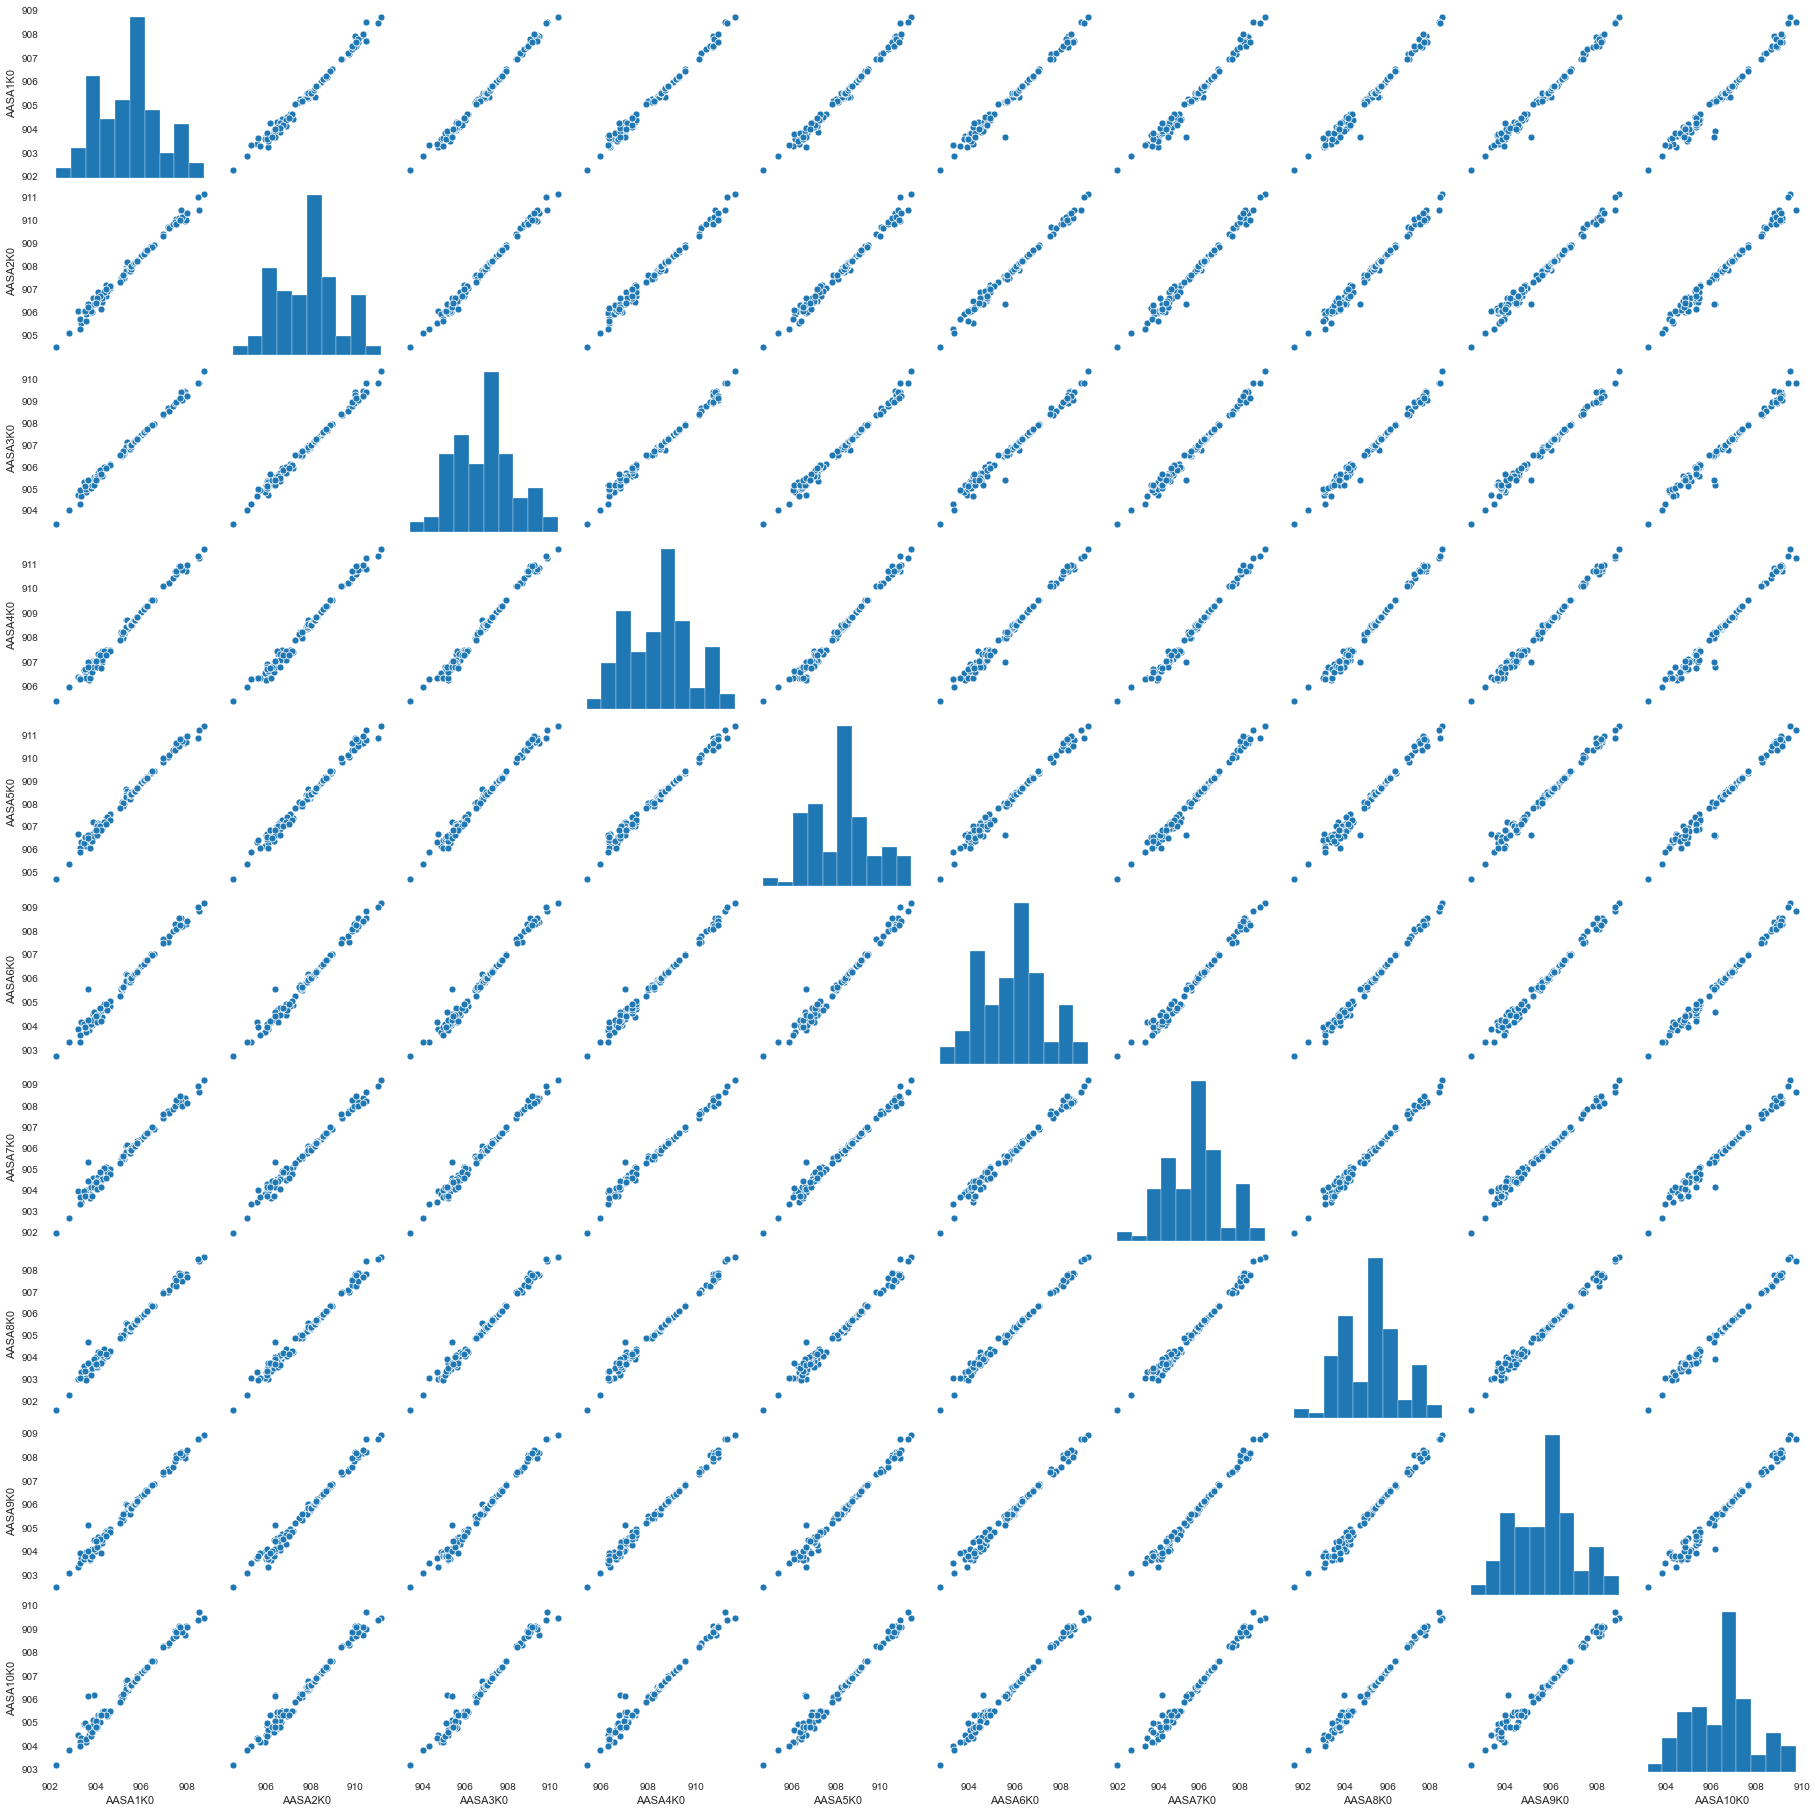

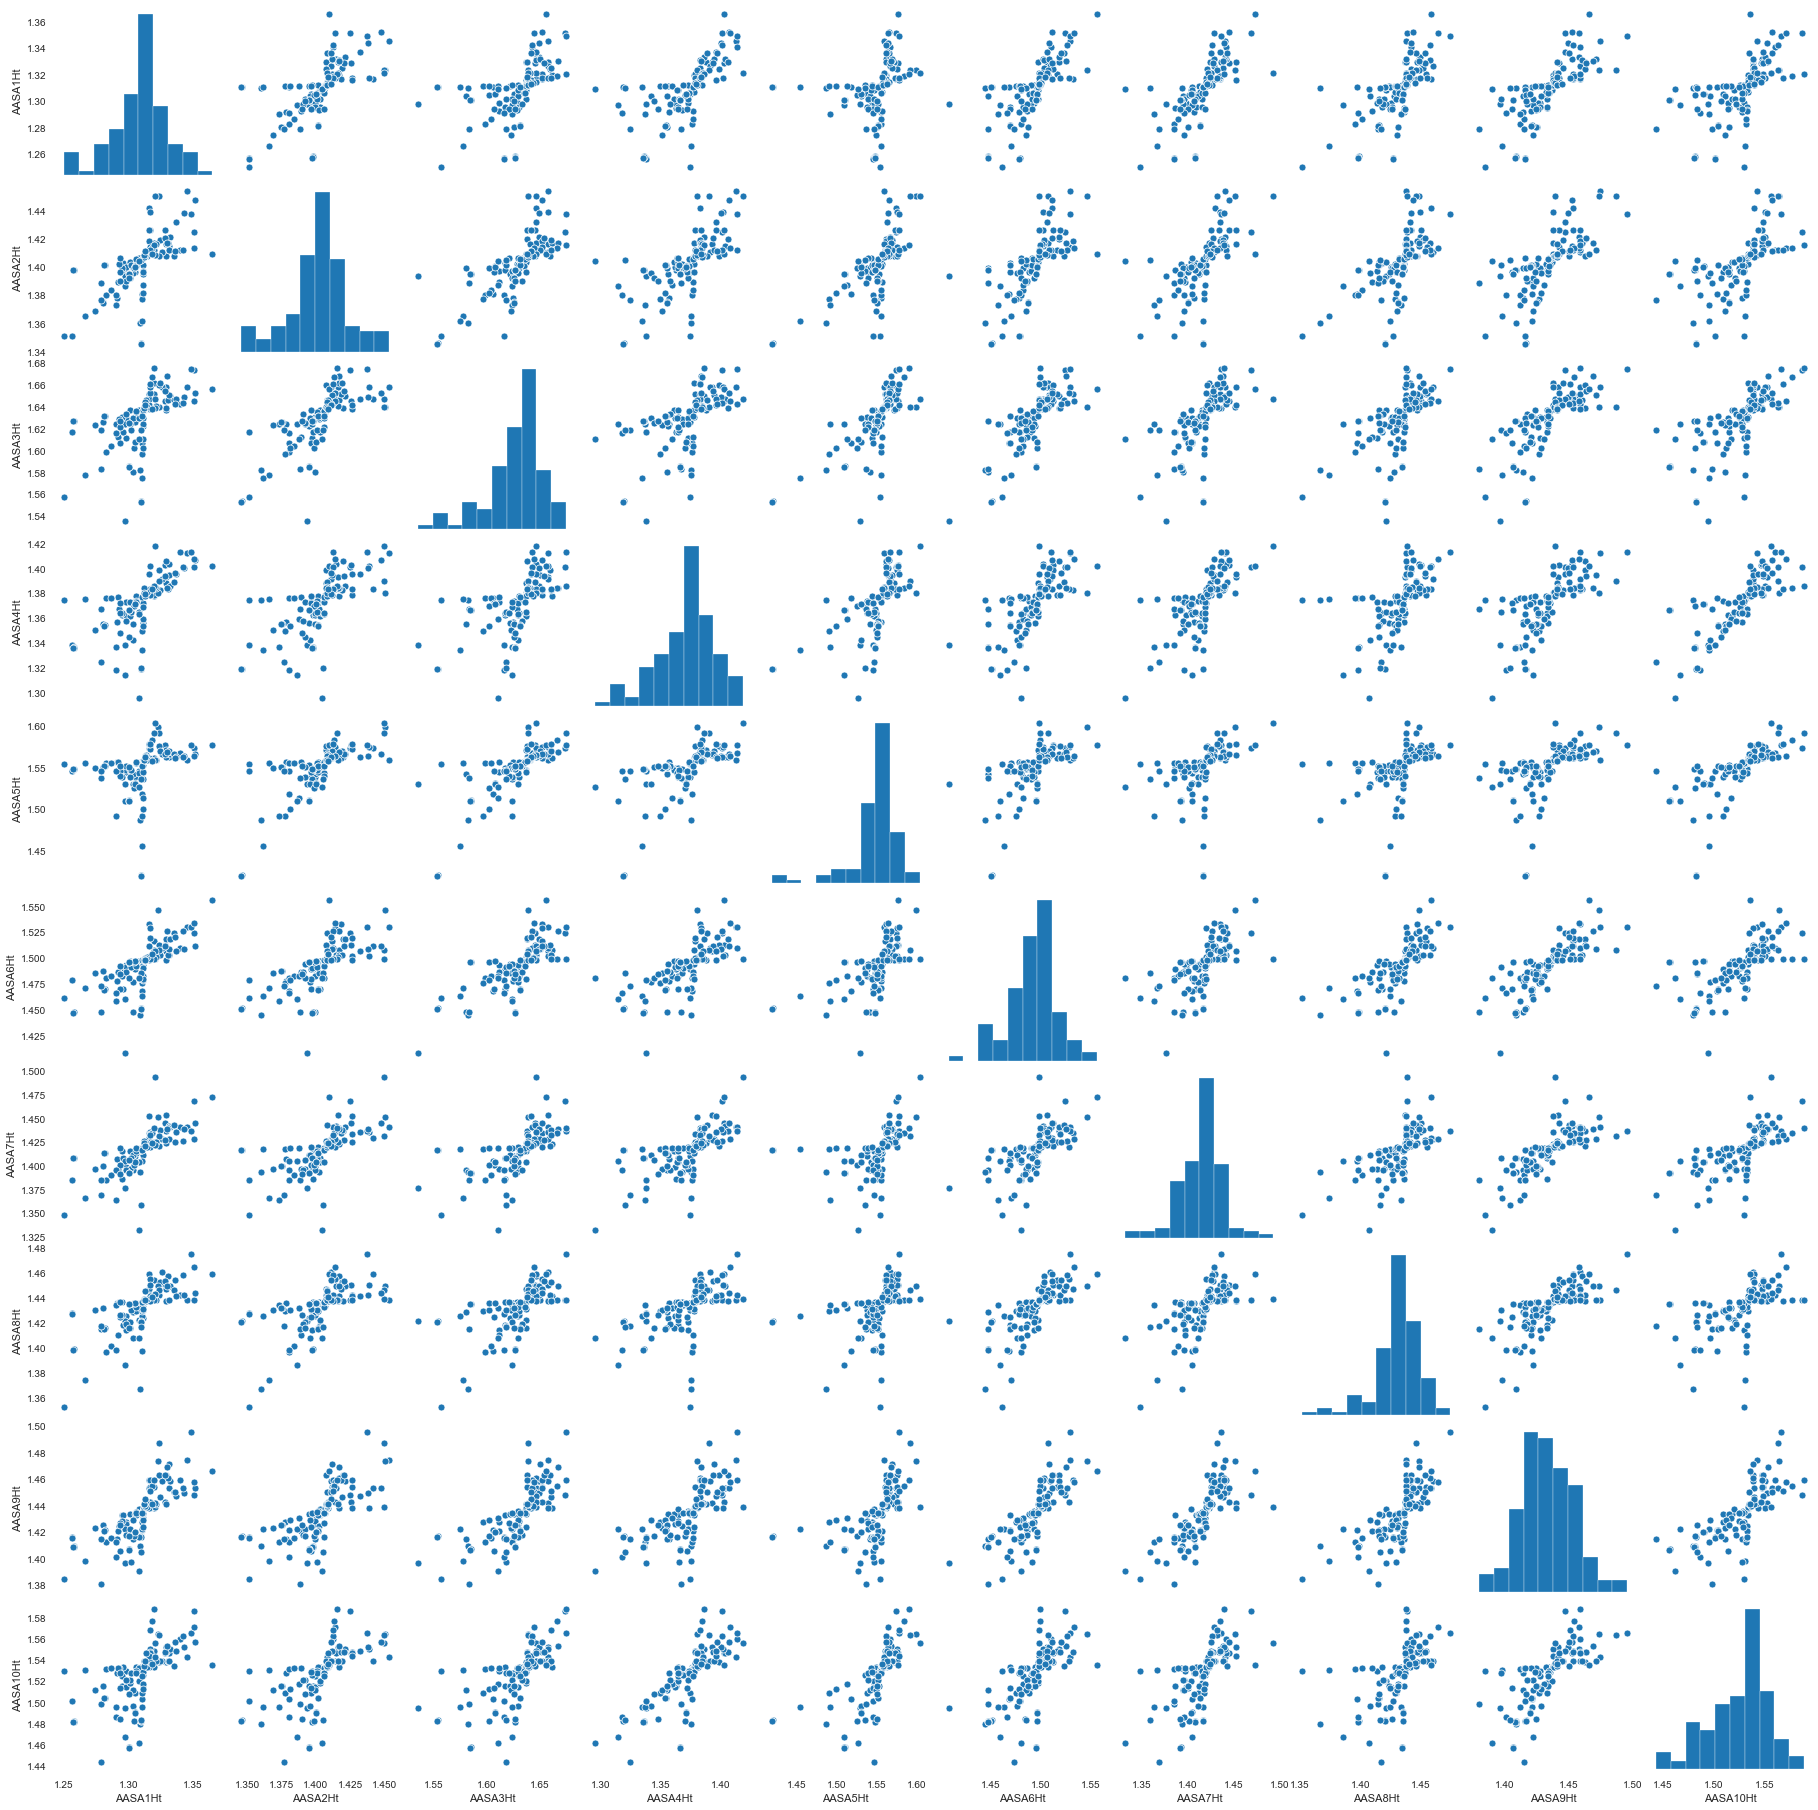

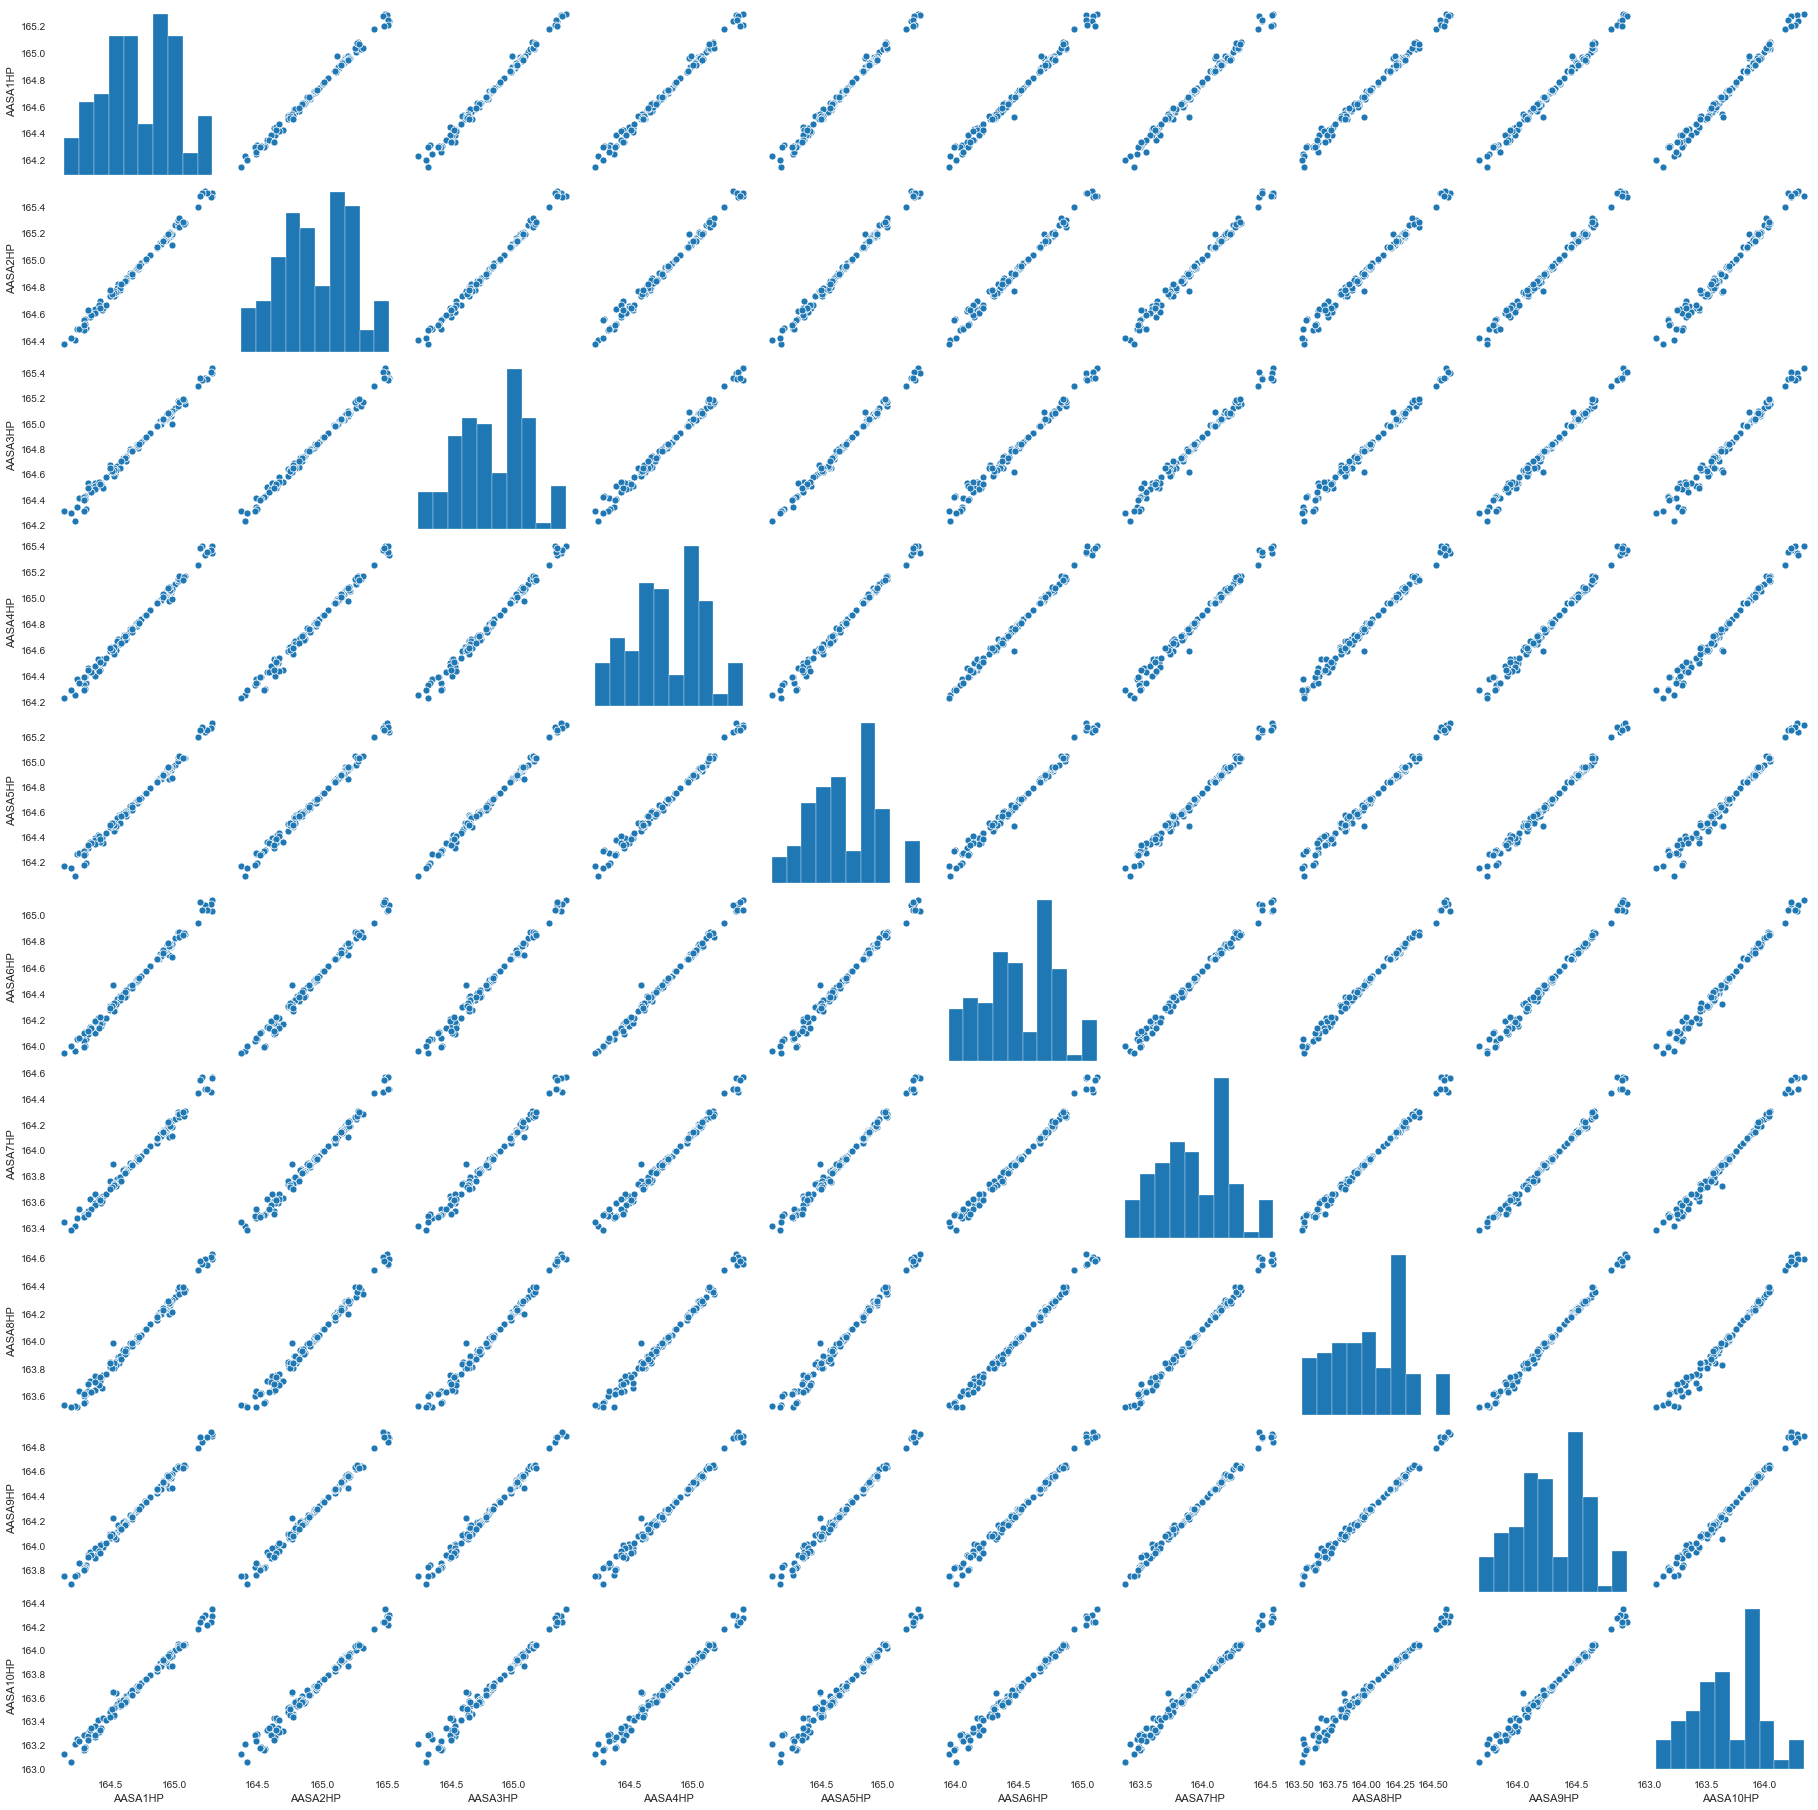

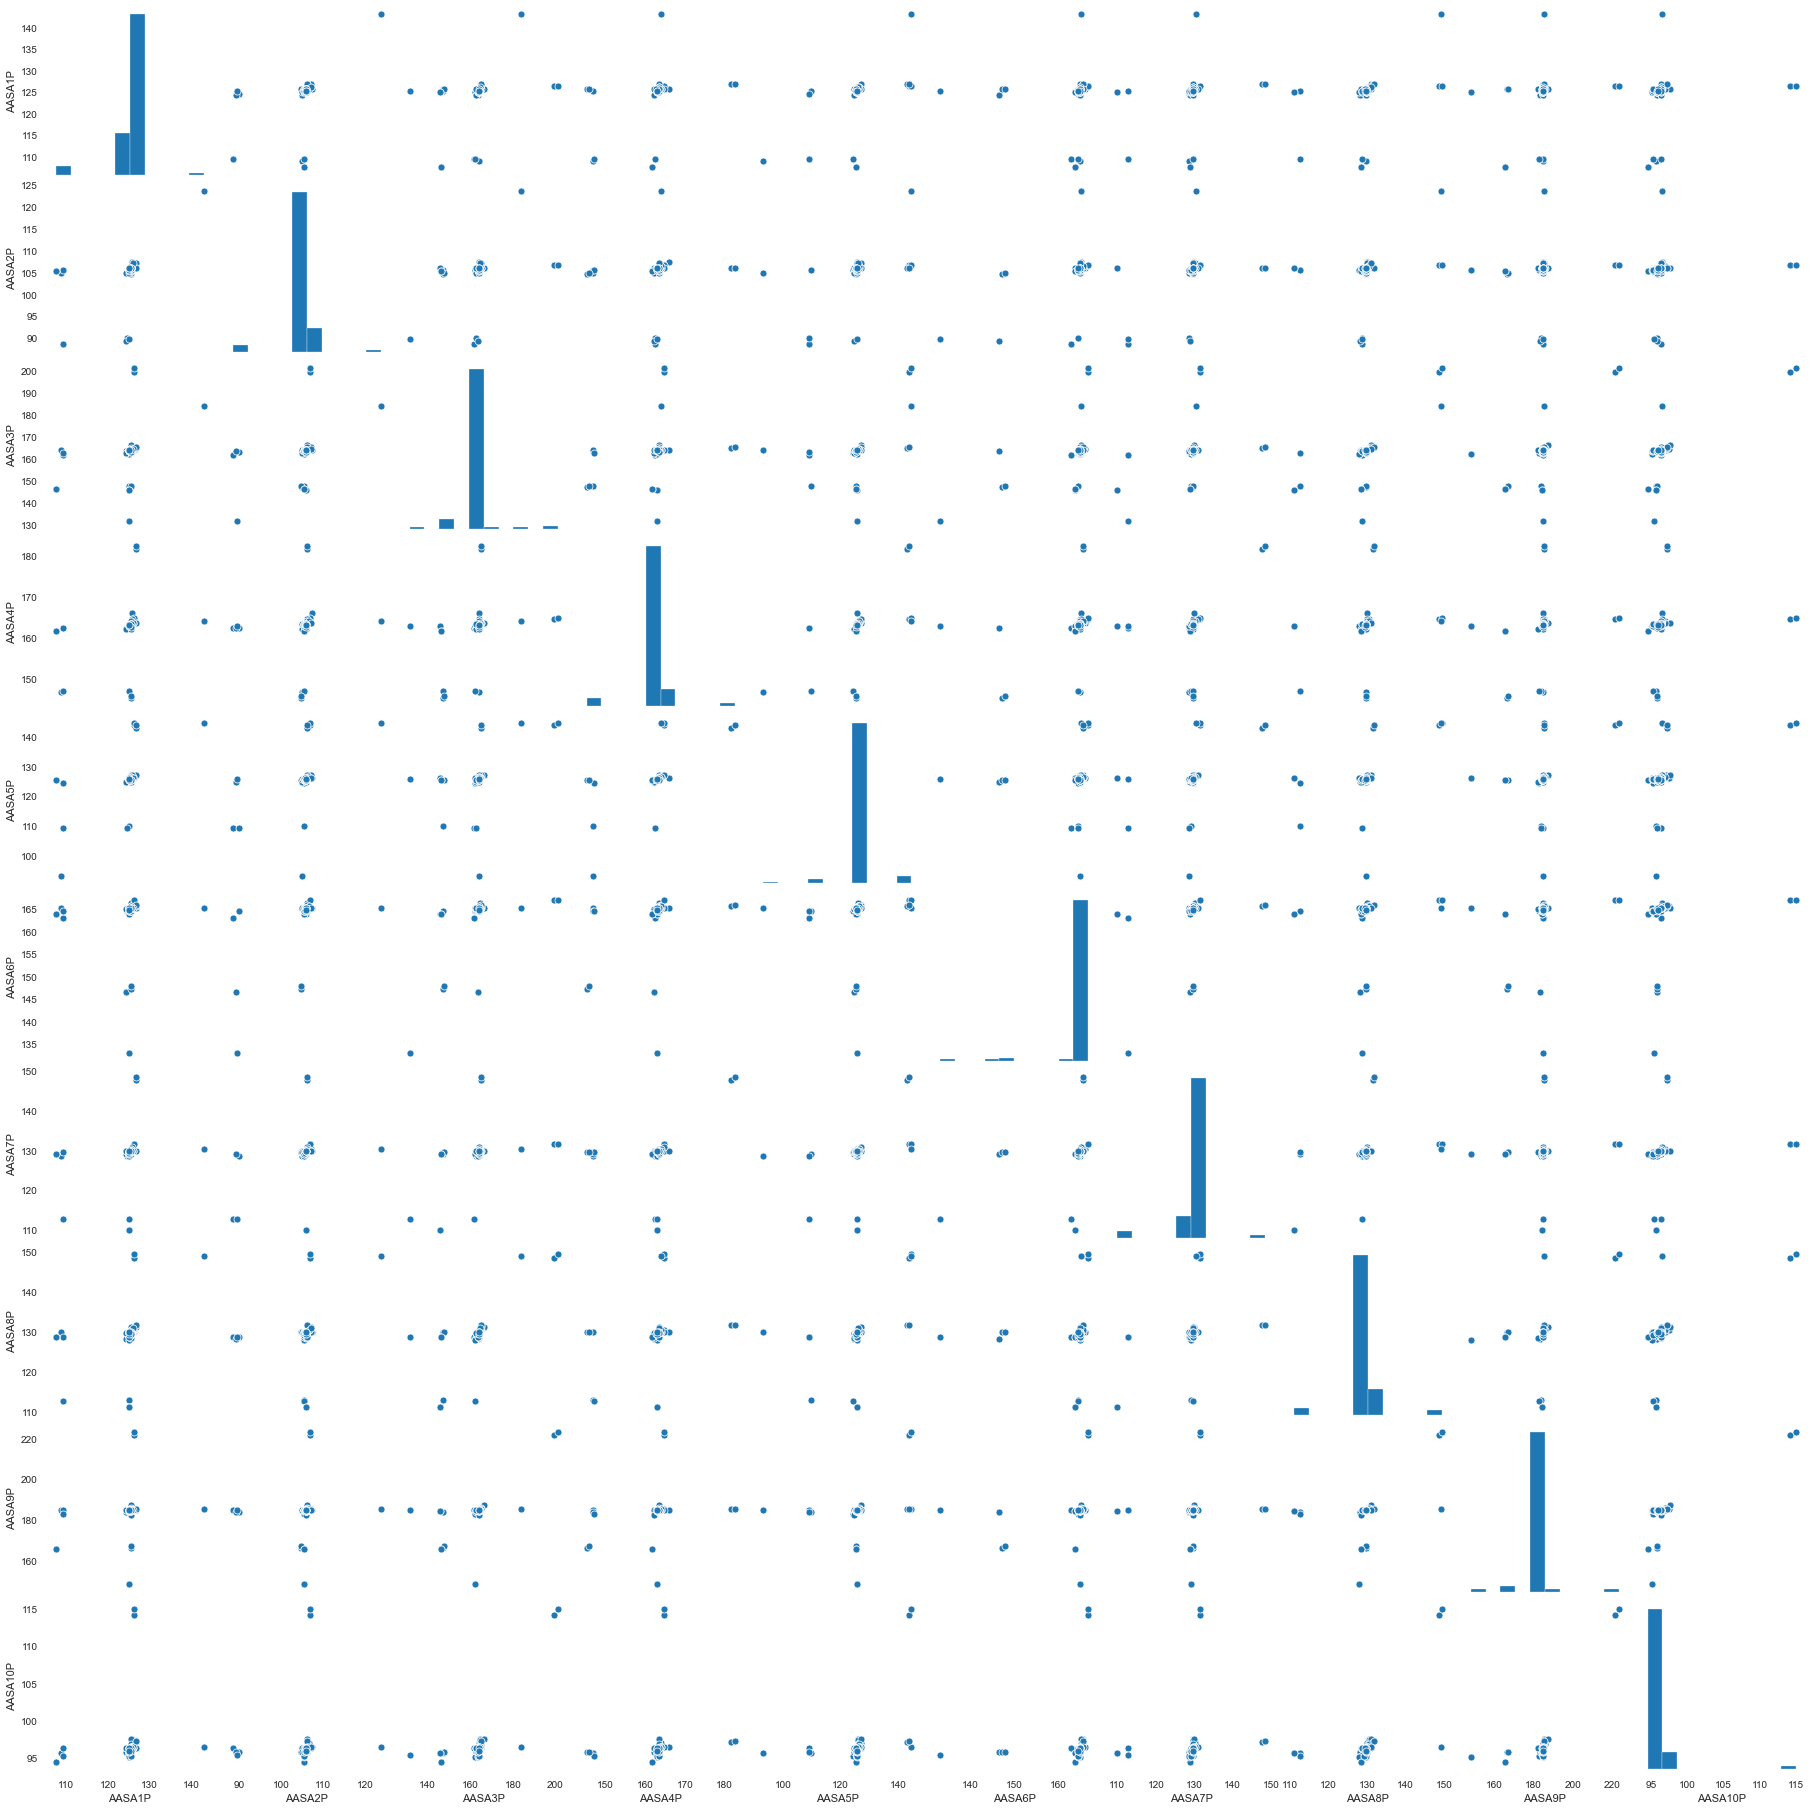

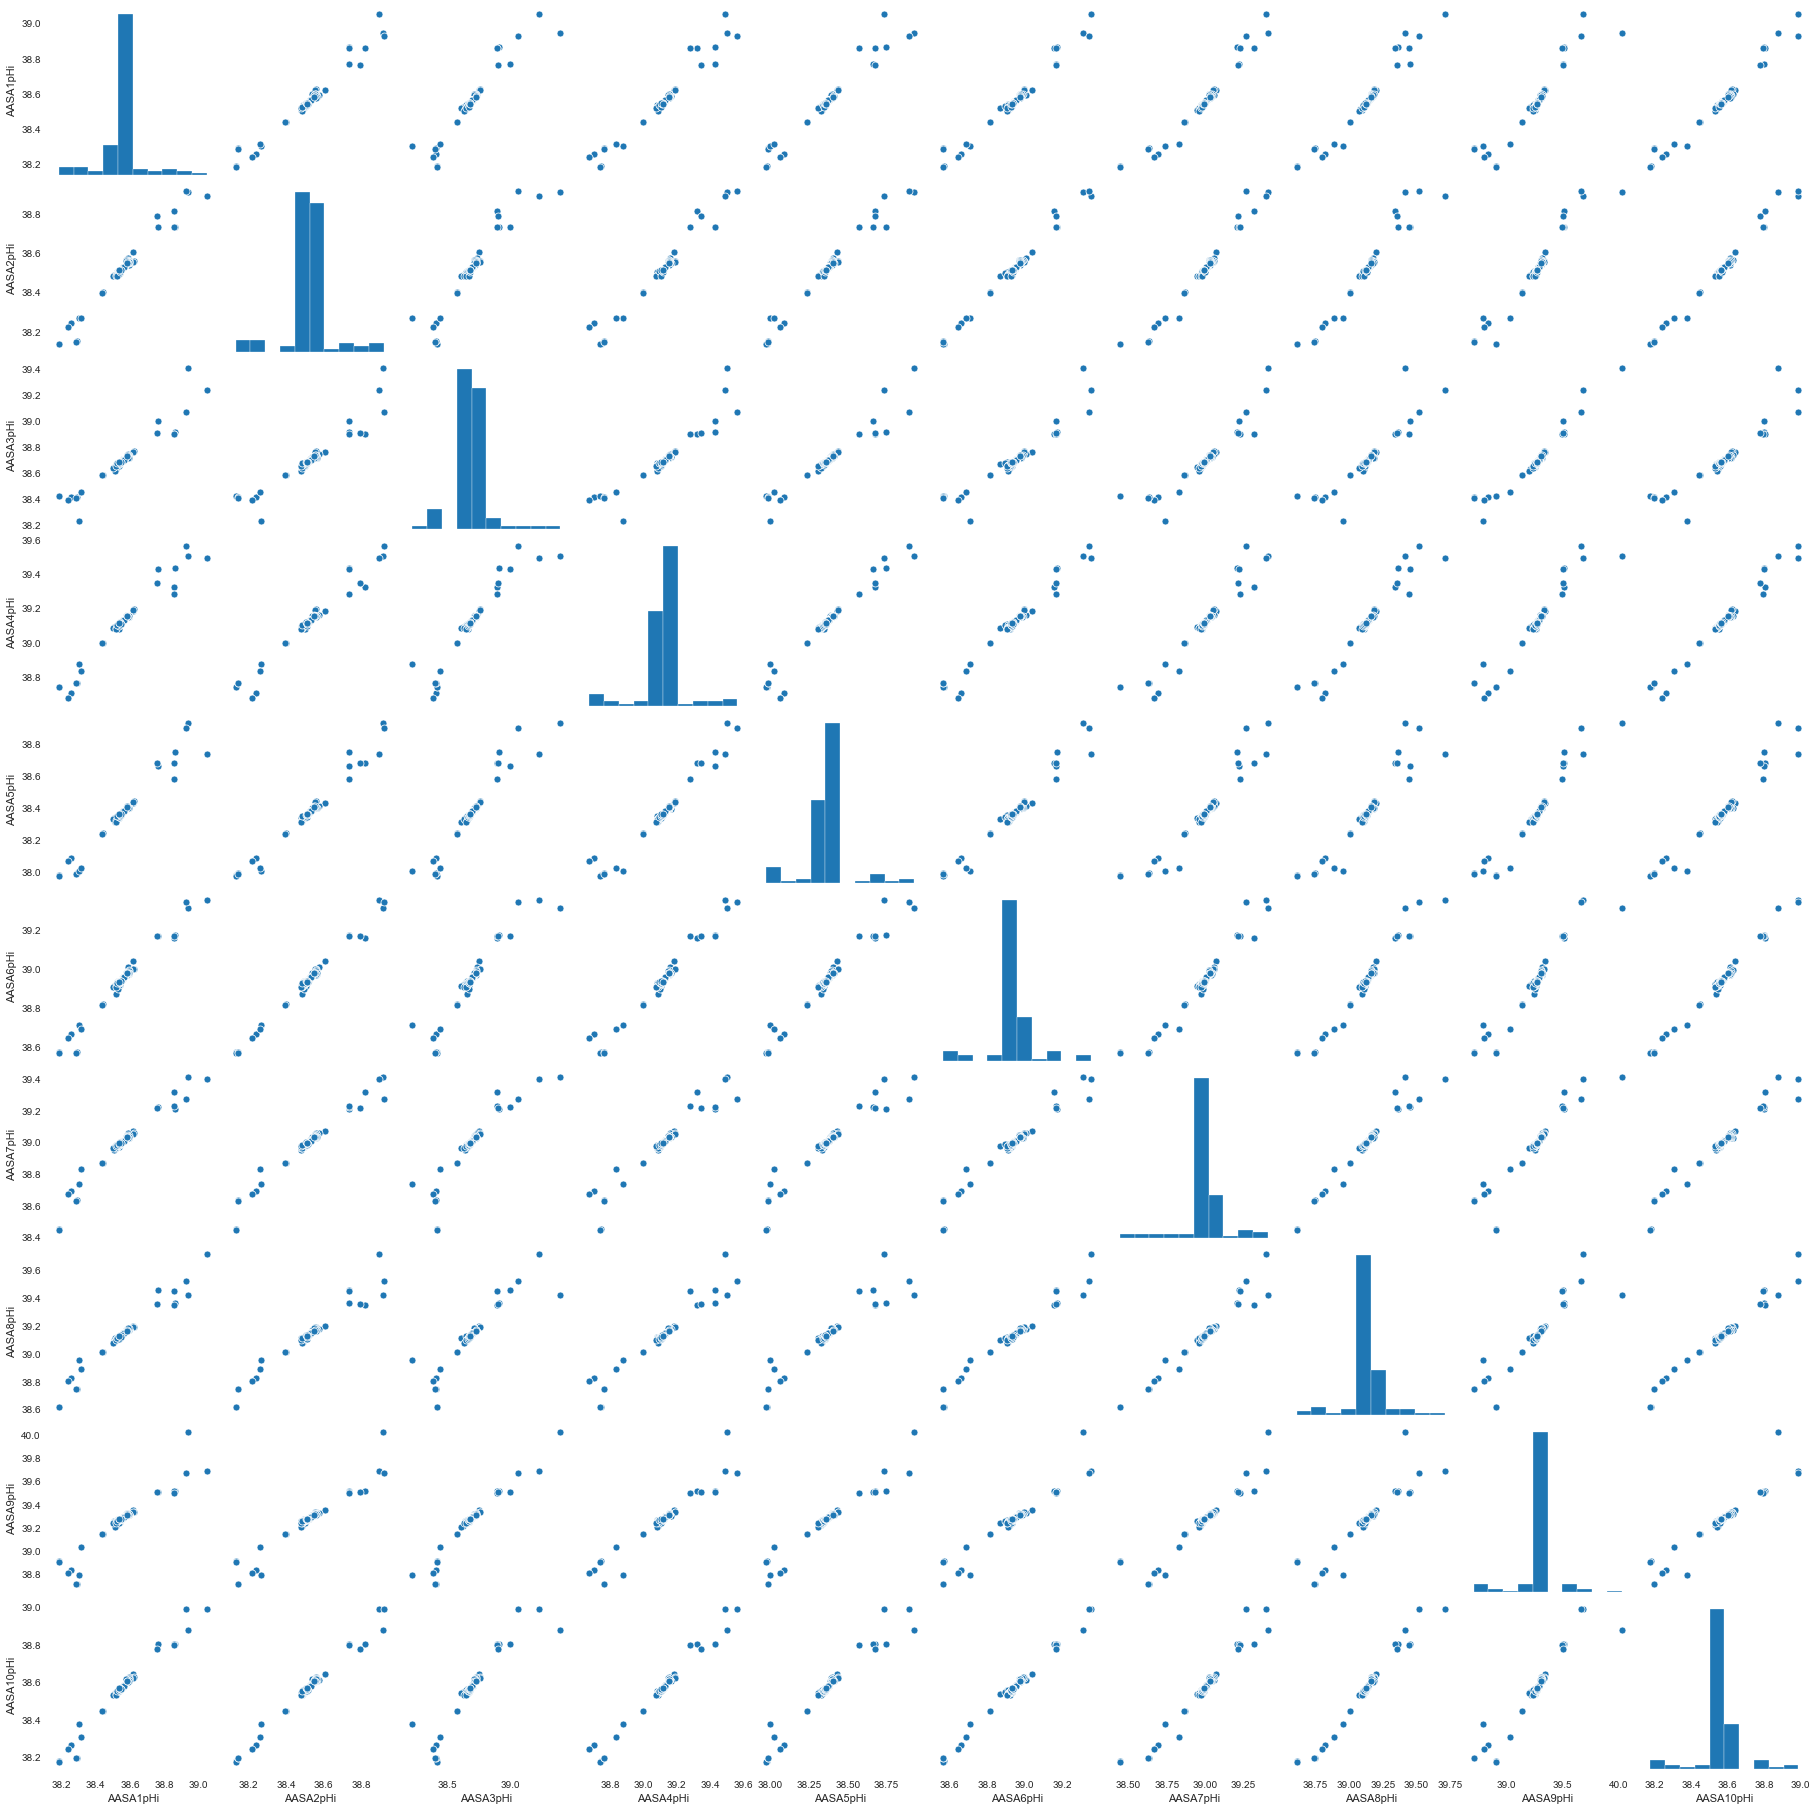

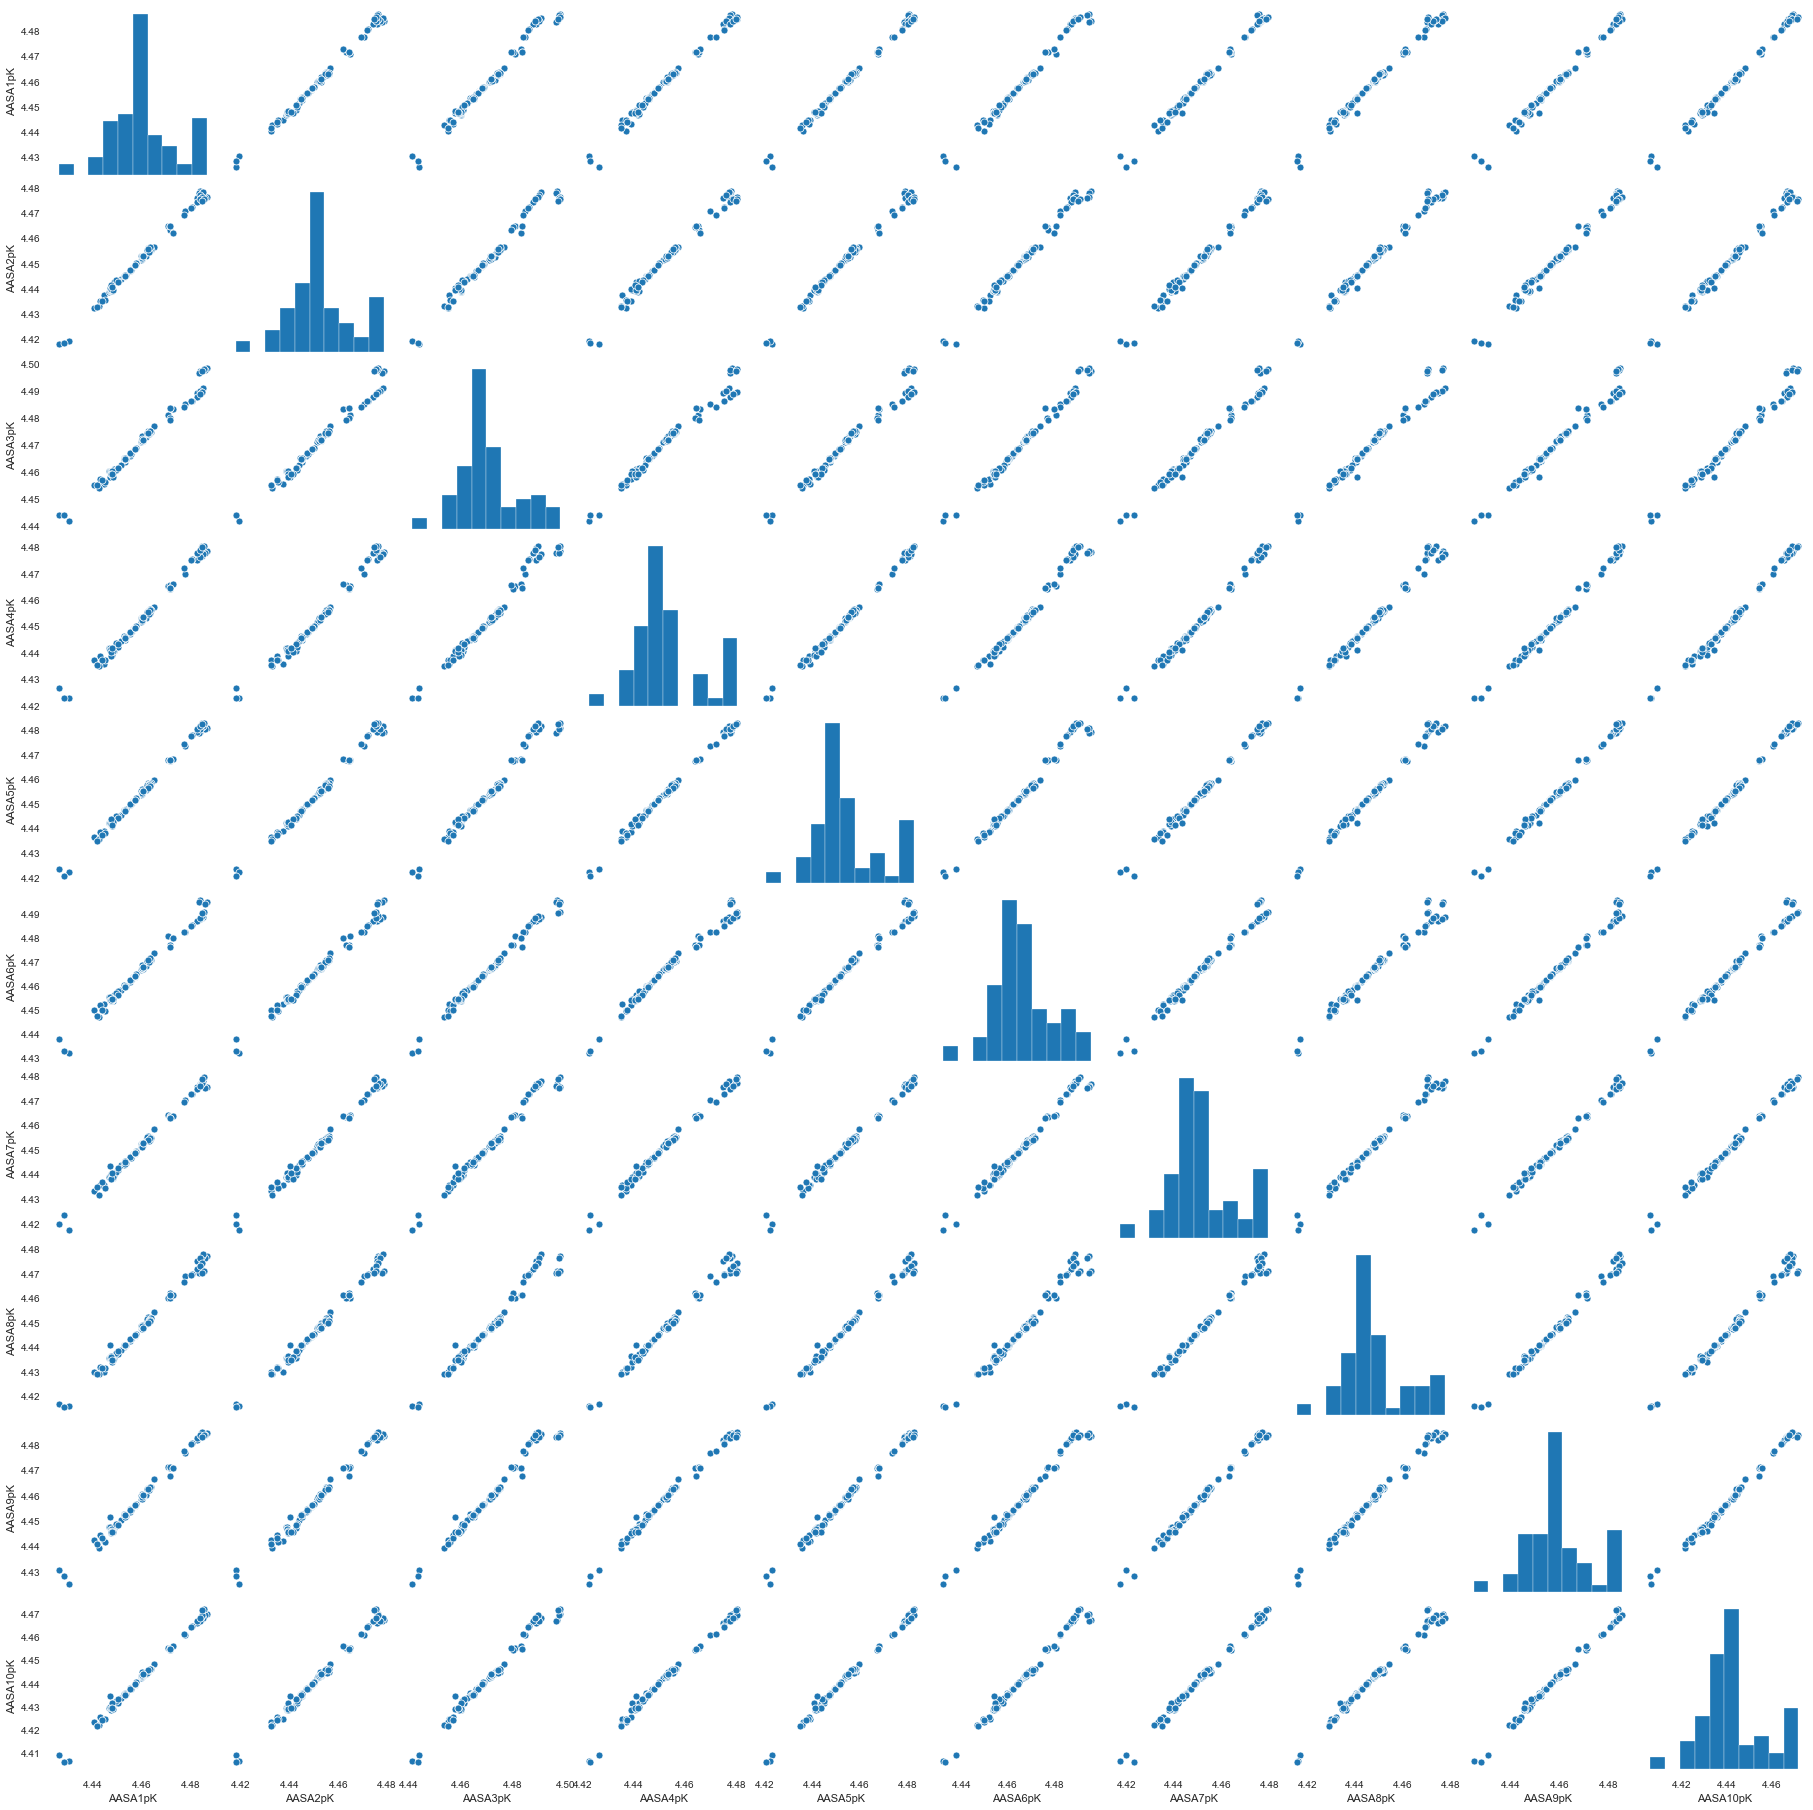

Error in callback <function flush_figures at 0x000001C6C3AF1F78> (for post_execute):


KeyboardInterrupt: 

In [40]:
for i in range(48):
    sns_plot = sns.pairplot(HLYZ.iloc[:, 10 * i + 2: 10 * i + 12])
    
    #For saving the image as a png file
    #sns_plot.savefig(str(i)+".png")

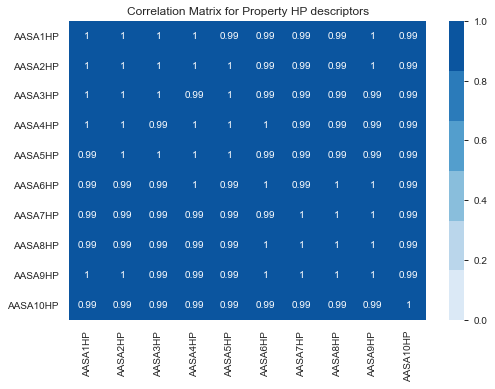

In [31]:
sns_plot = sns.heatmap(HLYZ.iloc[:, 22: 32].corr(method='pearson').abs(), annot=True, vmin=0, cmap=sns.color_palette("Blues")).set_title('Correlation Matrix for Property HP descriptors')

#For saving the image as a png file
#fig = sns_plot.get_figure()
#fig.savefig('heat.png') 

#### Target variable balance

Stability is a real-valued variable. However, there are implicit domain-dependant class labels. Negative values in stability are associated with **_destabilizing_** mutations. Positive values, including zero, are associated with **_non-destabilizing_** mutations.

In [34]:
def discretize_stability(df):
    return pd.cut(df['stability'],
           bins=[np.NINF, -0.0001,0, np.Inf], 
           labels=['Negative variation', 'No variation','Positive variation'], right=True)

In [44]:
#Returns a dataframe with the variation cases proportion of a dataset
def case_proportion(df):
    return pd.DataFrame({'instances': discretize_stability(df).value_counts(),
                                     'variation': discretize_stability(df).value_counts().index.to_list()})

In [36]:
def show_case_proportion_plot(df, title):
    fig = px.pie(df, values='instances', names='variation',title=title,
            color='variation', color_discrete_map = {'Negative variation': px.colors.qualitative.T10[2], 
                                                     'No variation':px.colors.qualitative.T10[9], 
                                                     'Positive variation': px.colors.qualitative.T10[4]})
    fig.show()

In [46]:
show_case_proportion_plot(case_proportion(p1STN), 'Cases proportion in Dataset 1STN')
show_case_proportion_plot(case_proportion(p4LYZ), 'Cases proportion in Dataset 4LYZ')
show_case_proportion_plot(case_proportion(p1BPI), 'Cases proportion in Dataset 1BPI')
show_case_proportion_plot(case_proportion(HLYZ), 'Cases proportion in Dataset HLYZ')

#### Stability distribution comparison

In [38]:
fig = px.box(p1STN, y='stability',
             boxmode="overlay", points='all', title = "Stability 1STN", labels={'y':"Stability"})

fig.show()

In [47]:
fig = px.box(p4LYZ, y='stability', boxmode="overlay", points='all', title = "Stability 4LYZ"
             , labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [48]:
fig = px.box(p1BPI, y='stability', boxmode="overlay", points='all', title = "Stability 1BPI"
             , labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [49]:
fig = px.box(HLYZ, y='stability', boxmode="overlay", points='all', title = "Stability HLYZ", 
             labels={'y':"Stability"}, hover_data=['id'])

fig.show()

In [50]:
df =  pd.concat([pd.DataFrame({'dataset': ['1STN' for i in range(len(p1STN['stability']))], 'stability' : p1STN['stability']}),
          pd.DataFrame({'dataset': ['4LYZ' for i in range(len(p4LYZ['stability']))], 'stability' : p4LYZ['stability']}),
          pd.DataFrame({'dataset': ['1BPI' for i in range(len(p1BPI['stability']))], 'stability' : p1BPI['stability']}),
        pd.DataFrame({'dataset': ['HLYZ' for i in range(len(HLYZ['stability']))], 'stability' : HLYZ['stability']})])
fig = px.box(df, y="stability", facet_col="dataset", color="dataset",
             boxmode="overlay", points='all', title='Stability comparison between datasets')

fig.show()

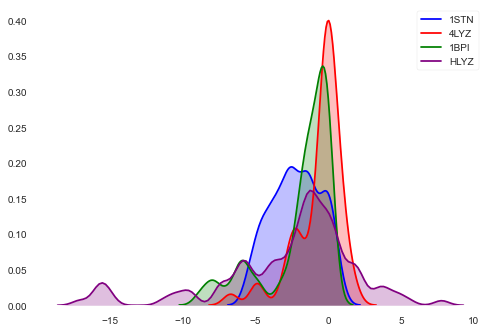

In [127]:
sns.kdeplot(p1STN['stability'], shade=True, color="b", bw=0.5, label='1STN')
sns.kdeplot(p4LYZ['stability'], shade=True, color="r", bw=0.5 , label='4LYZ')
sns.kdeplot(p1BPI['stability'], shade=True, color="g", bw=0.5, label='1BPI')
sns.kdeplot(HLYZ['stability'], shade=True, color="purple", bw=0.5, label='HLYZ')

#### Descriptors against Stability

These scatter plots help to find if descriptors follow, individually, a known function when plotted against the stability. If, for example, they follow a exponential-like function, applying a log transformation could help a to train a linear model on transformed data.

In [51]:
def plot_descriptors_against_stability(protein_data):
    for i in range(48):
        df = protein_data.iloc[:, np.r_[1, 10 * i + 2: 10 * i + 12]]
        sns_plot = sns.pairplot(df, y_vars="stability", x_vars=df.columns[1:len(df.columns)].values)
        #For saving the image as a png file
        sns_plot.savefig(str(i) + "_HLYZ_against_stability"+  ".png")

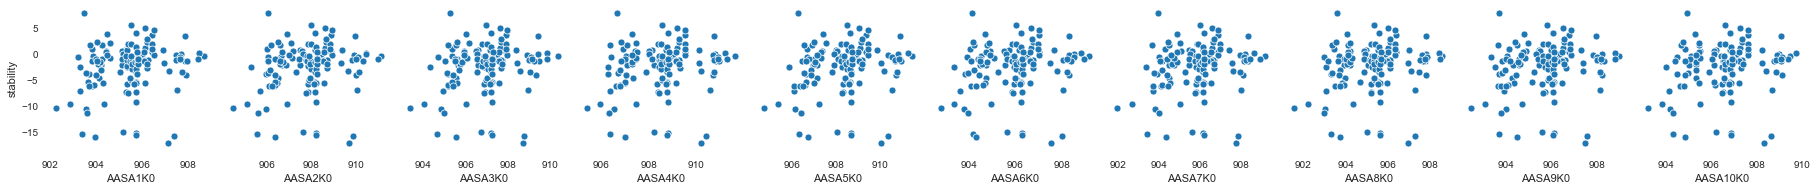

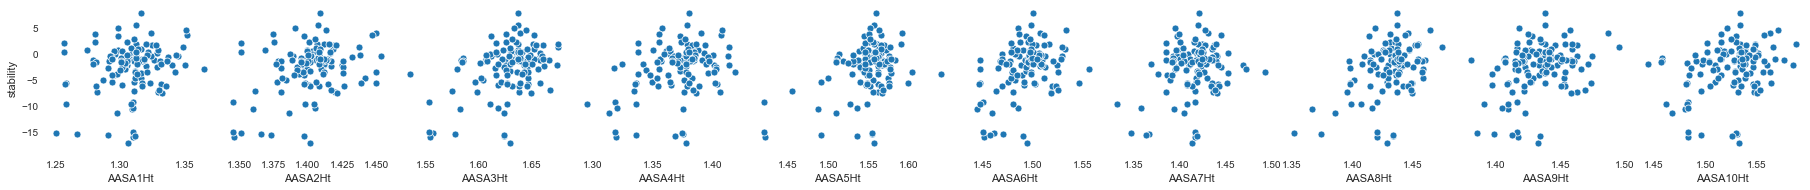

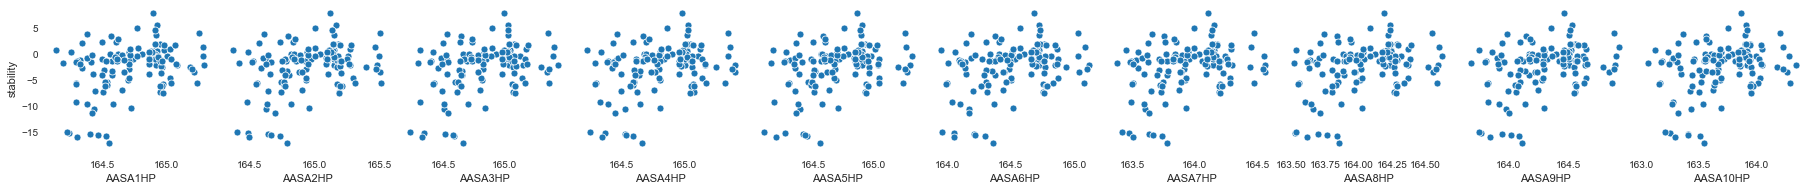

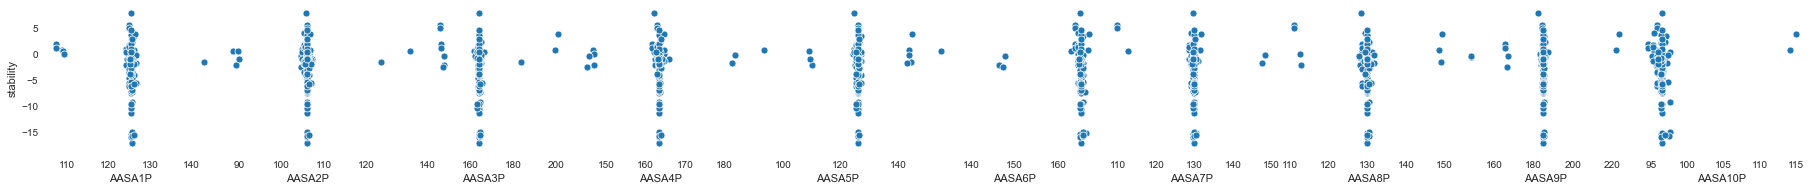

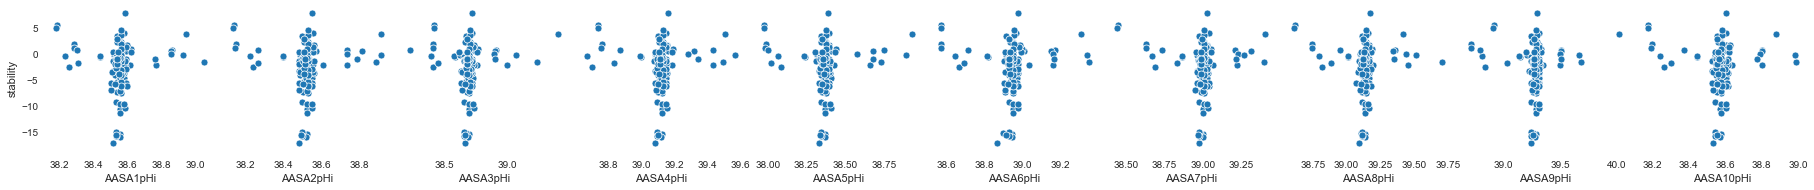

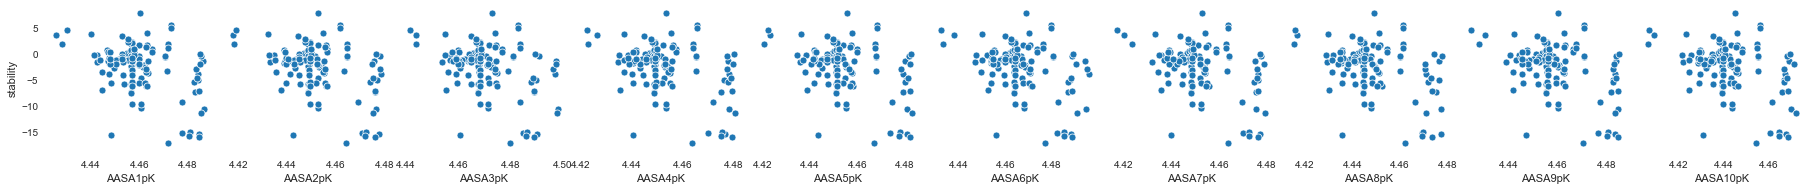

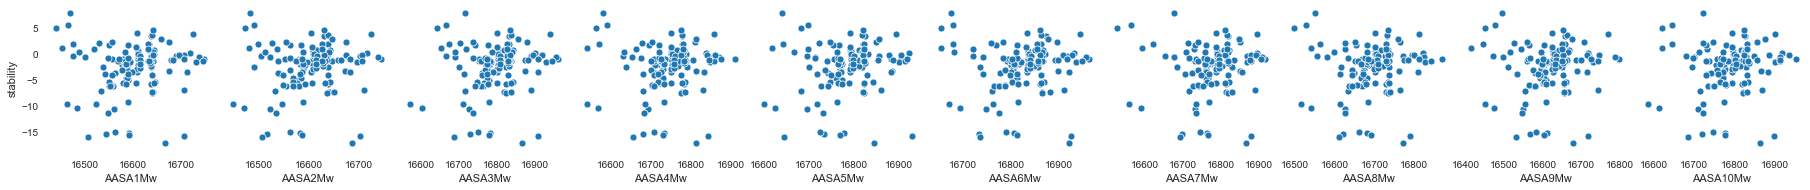

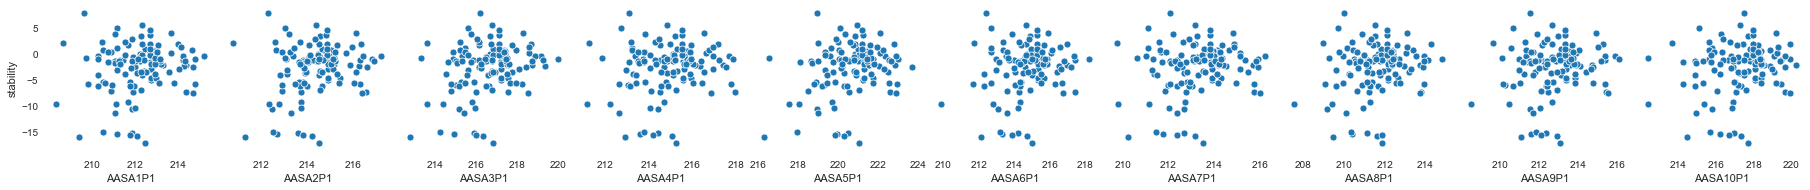

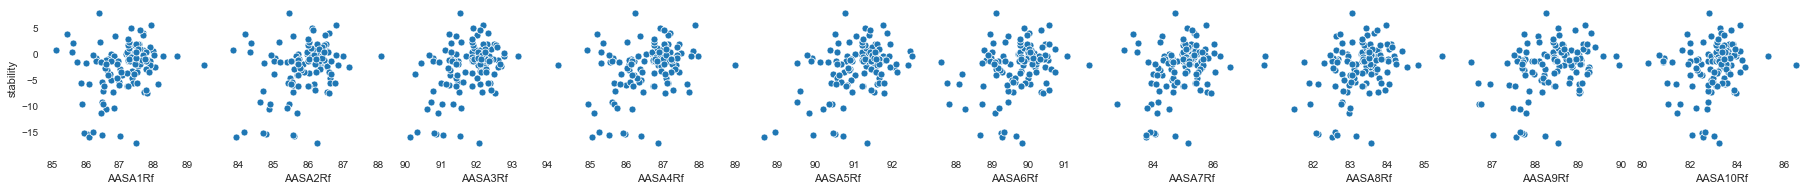

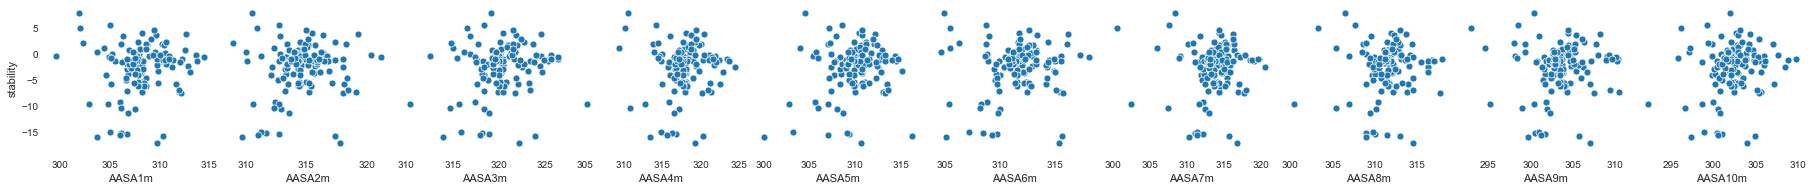

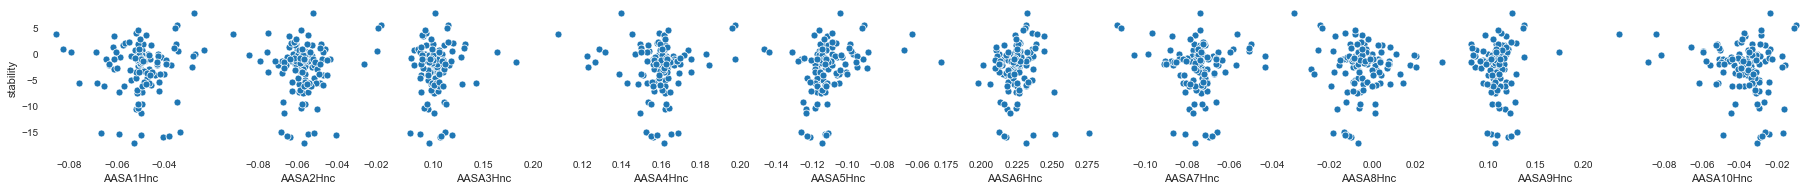

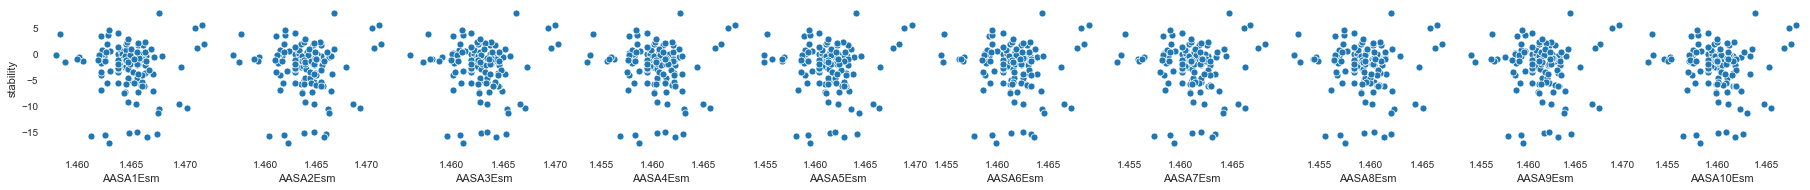

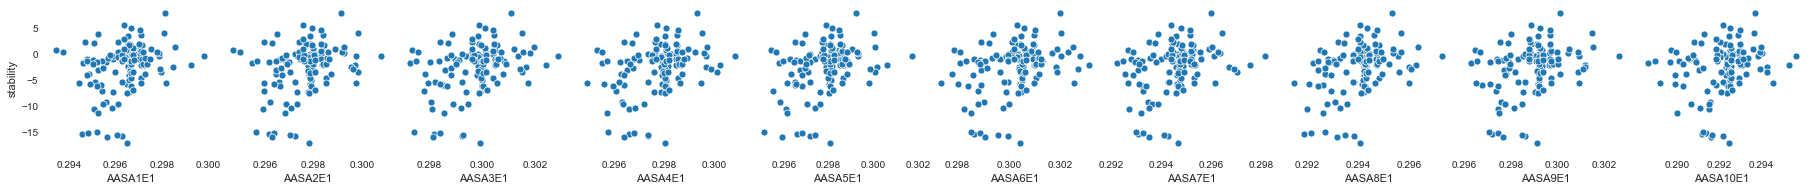

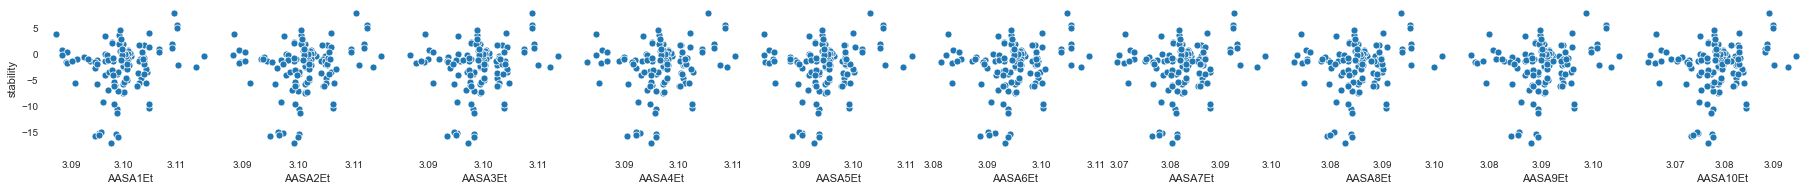

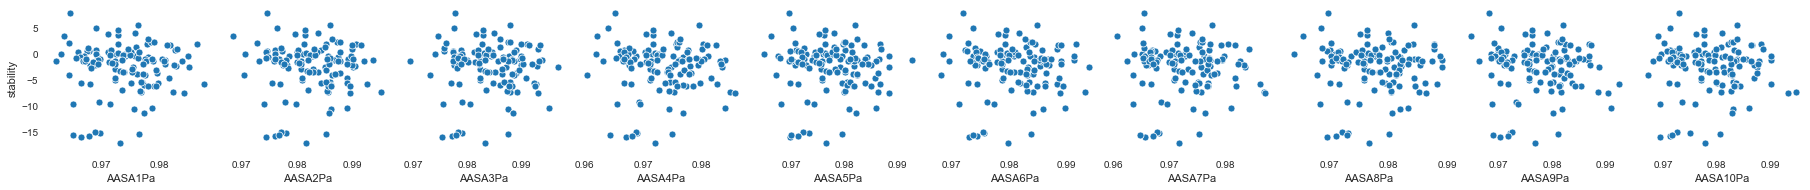

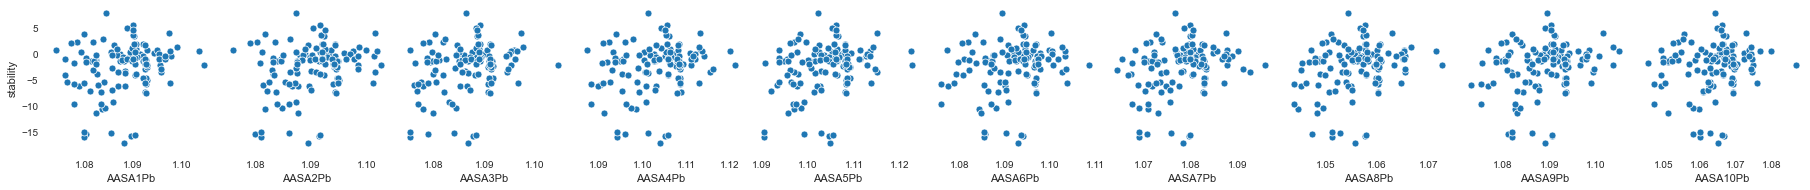

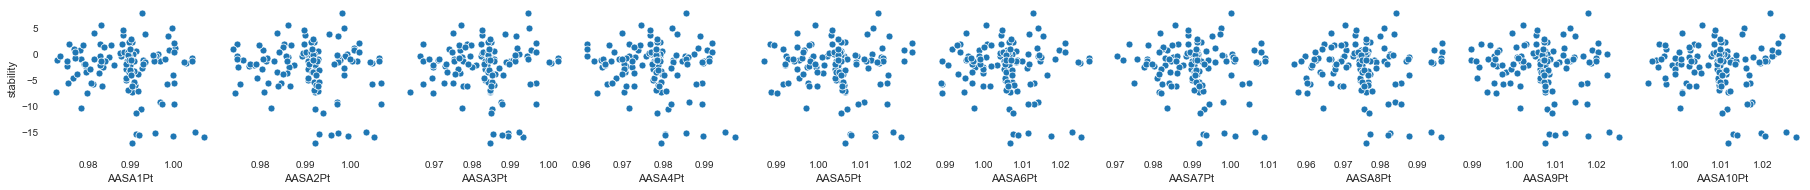

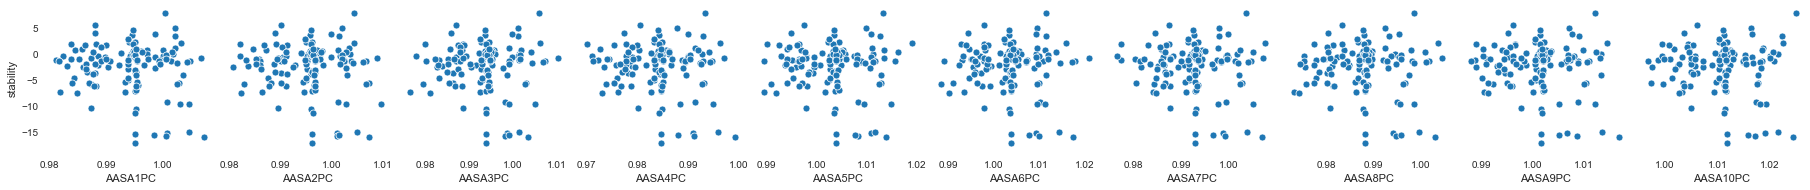

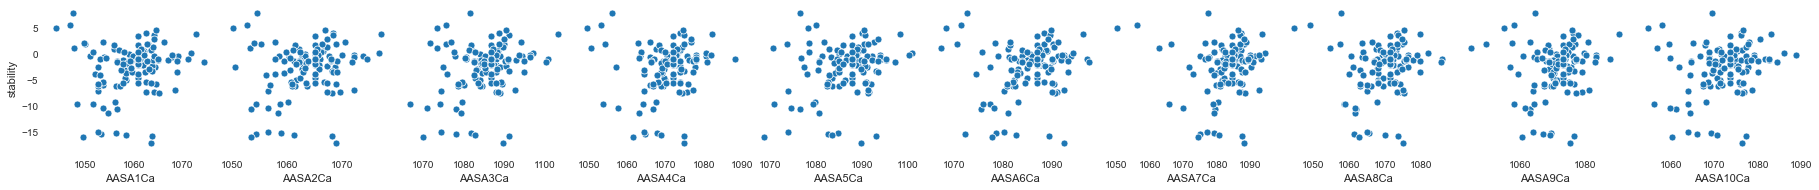

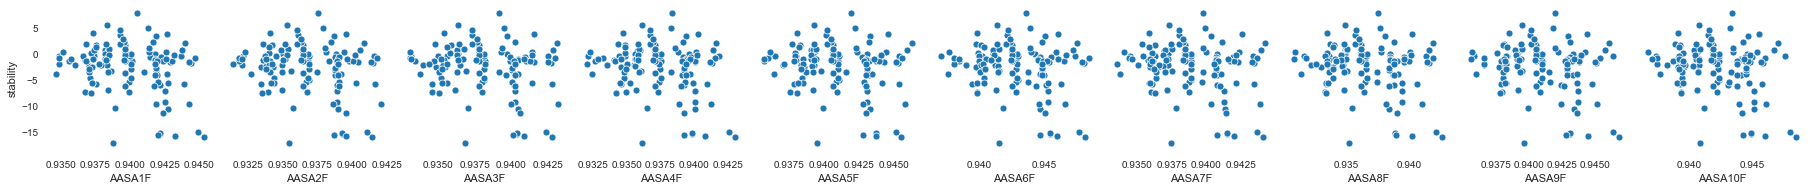

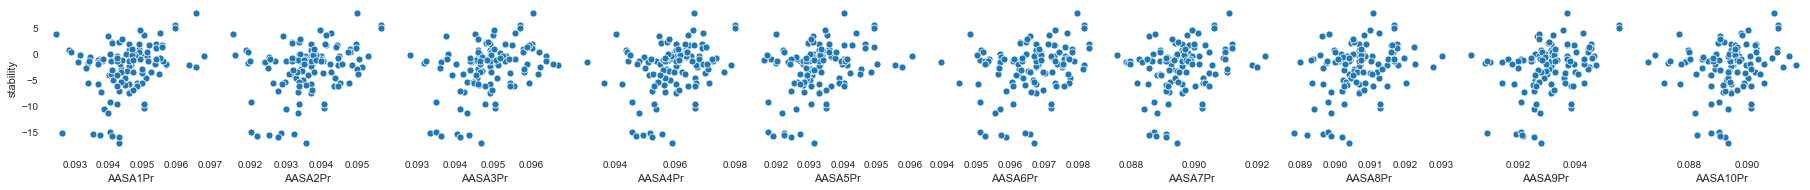

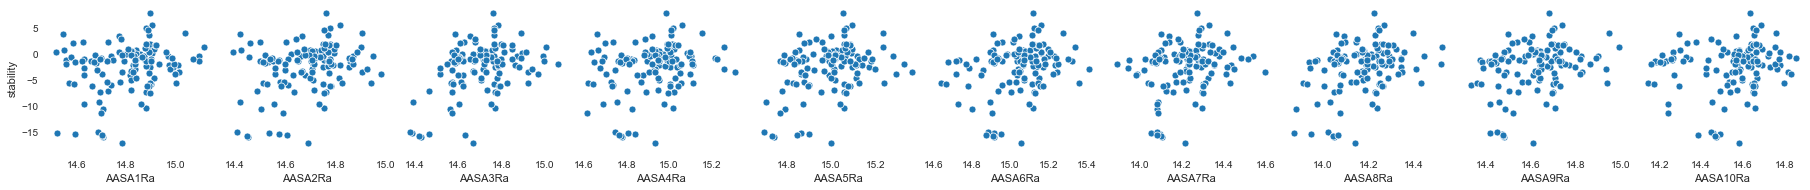

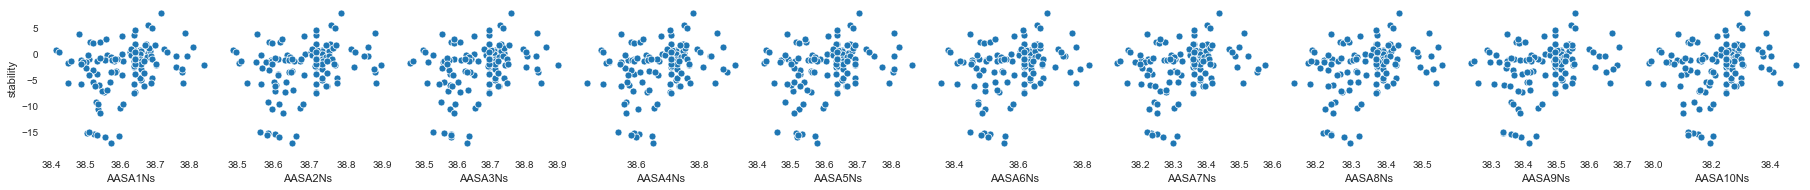

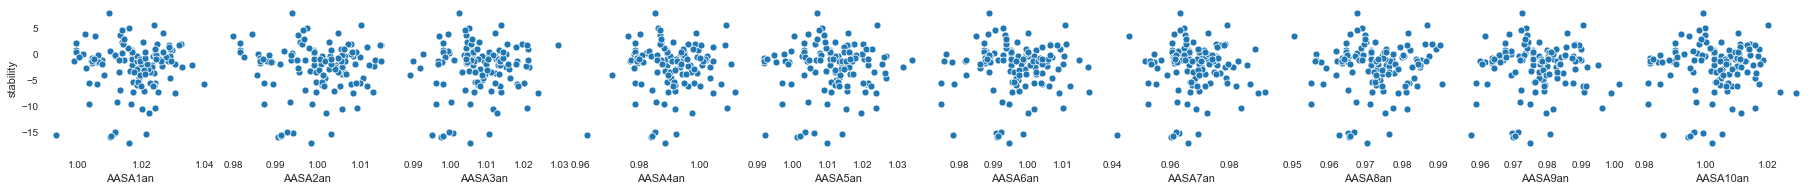

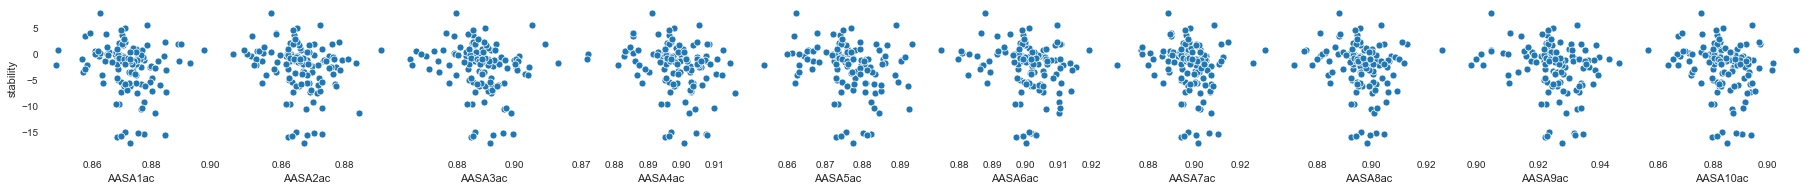

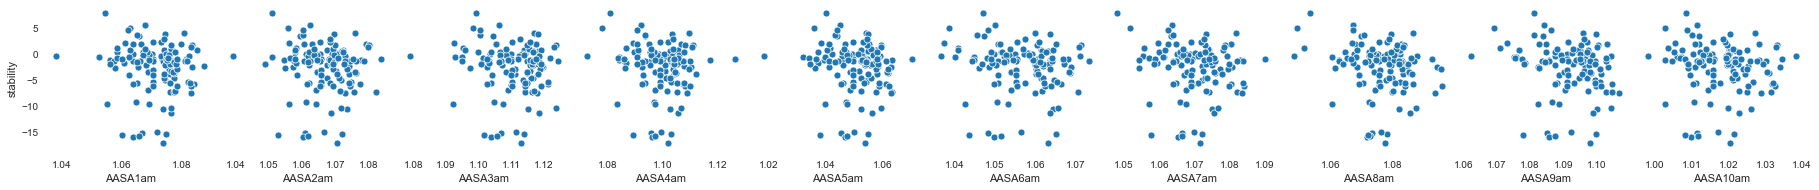

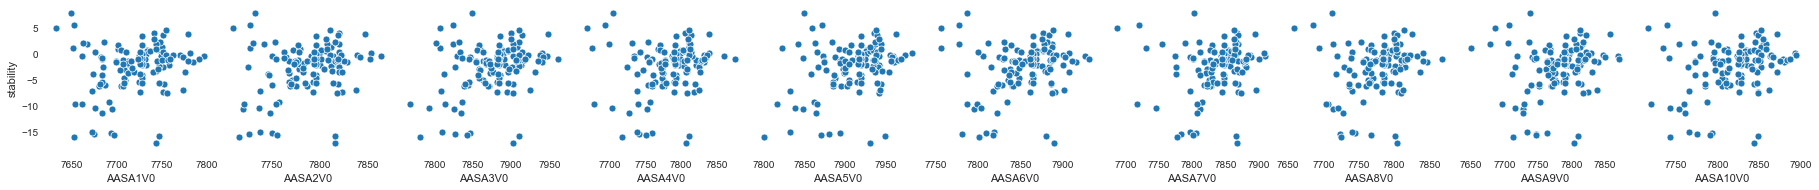

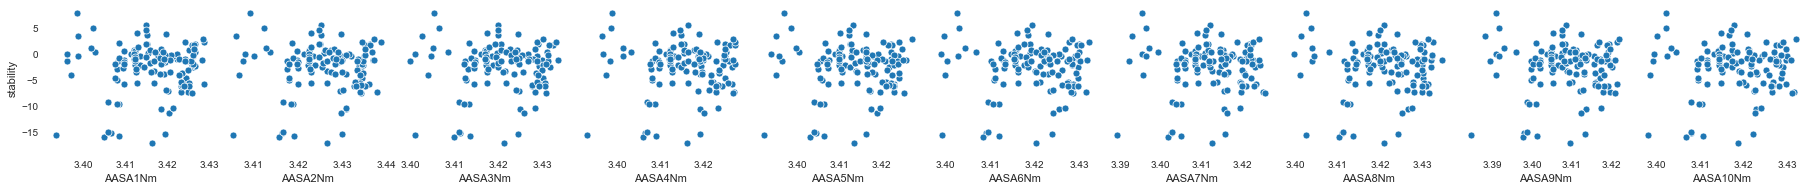

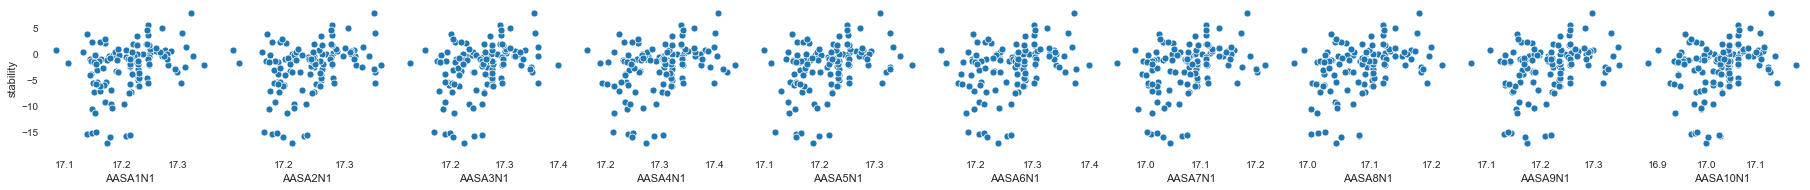

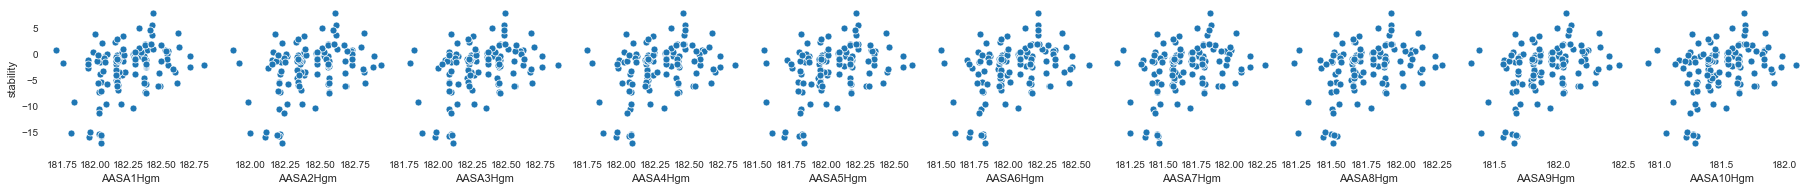

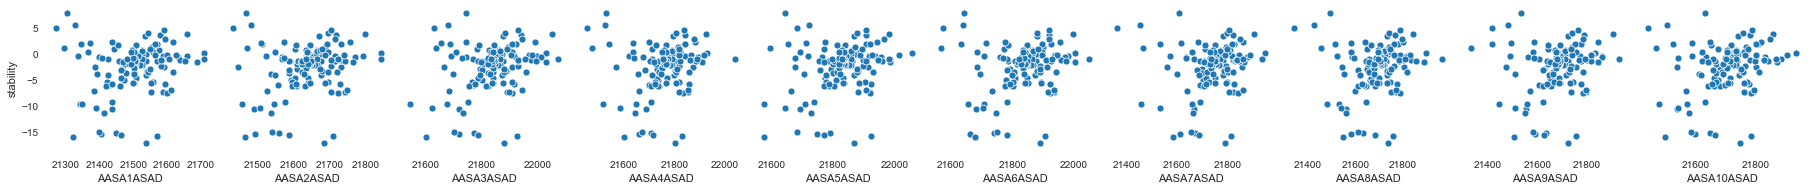

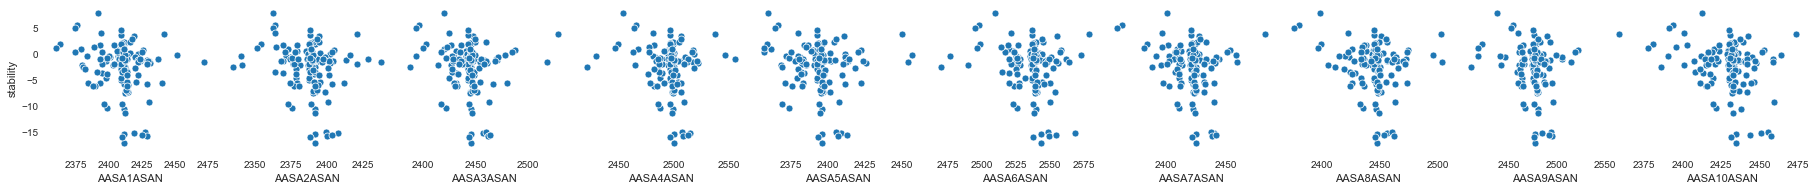

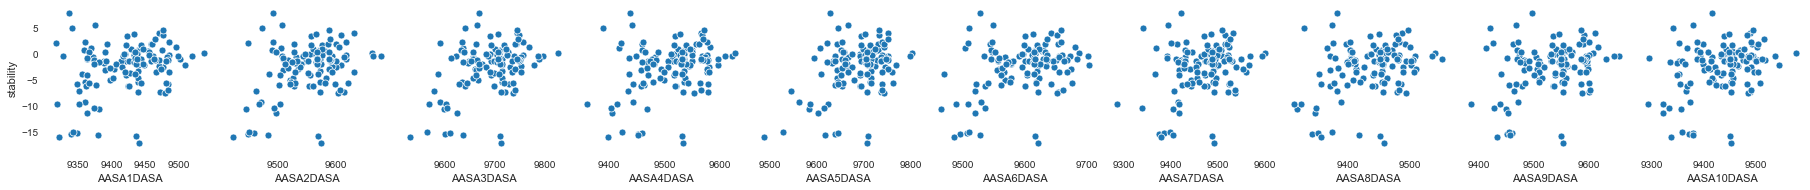

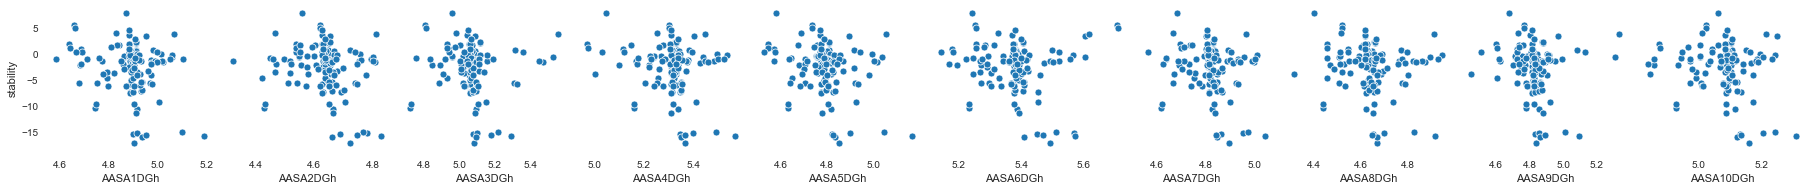

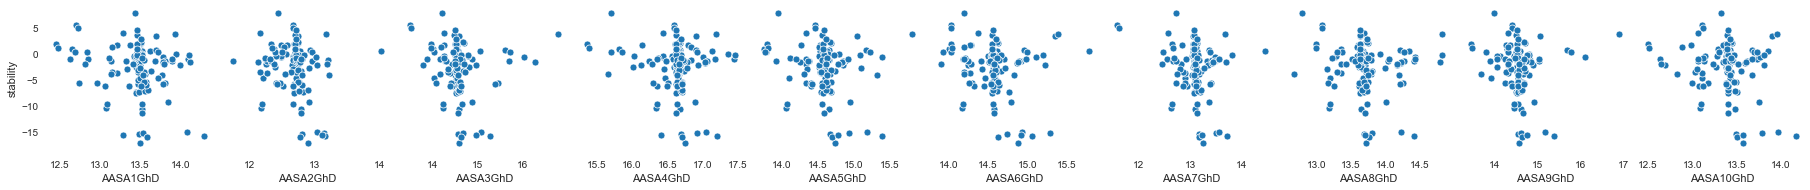

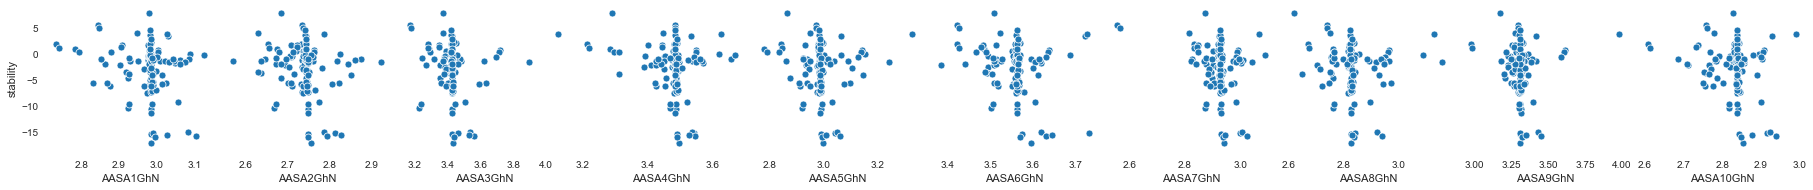

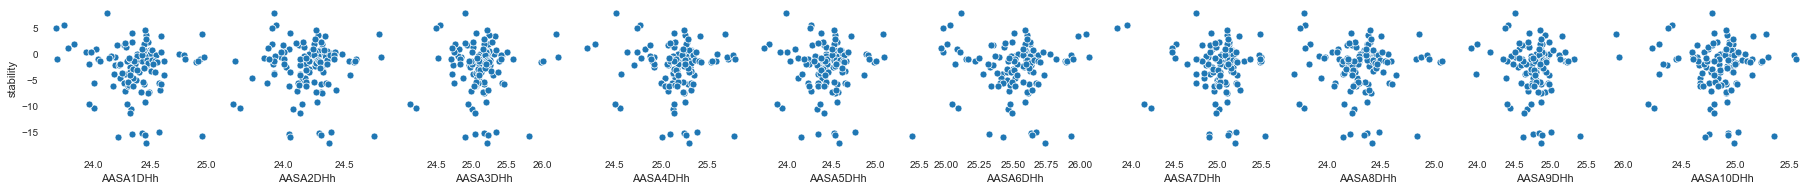

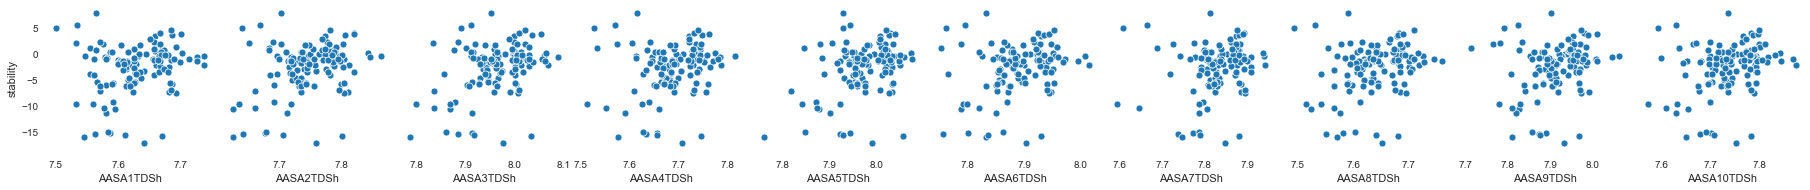

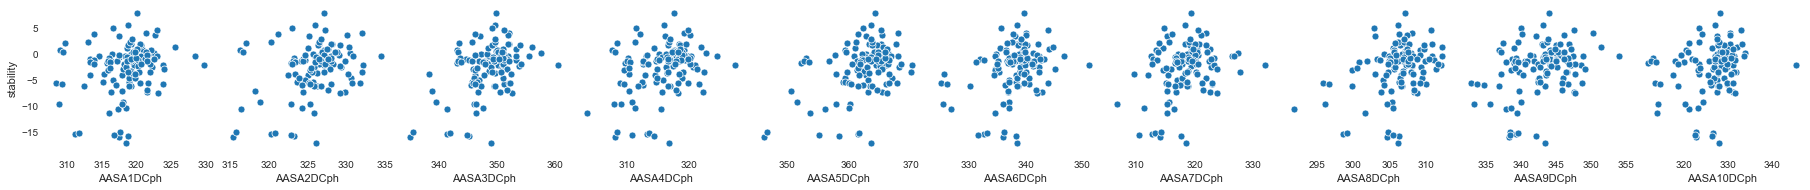

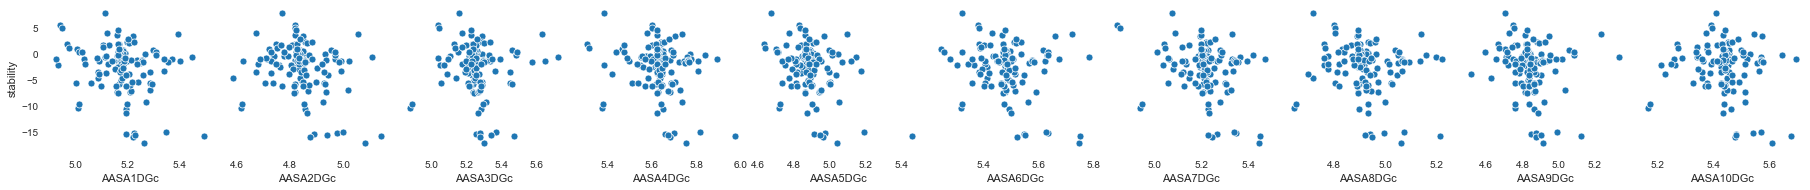

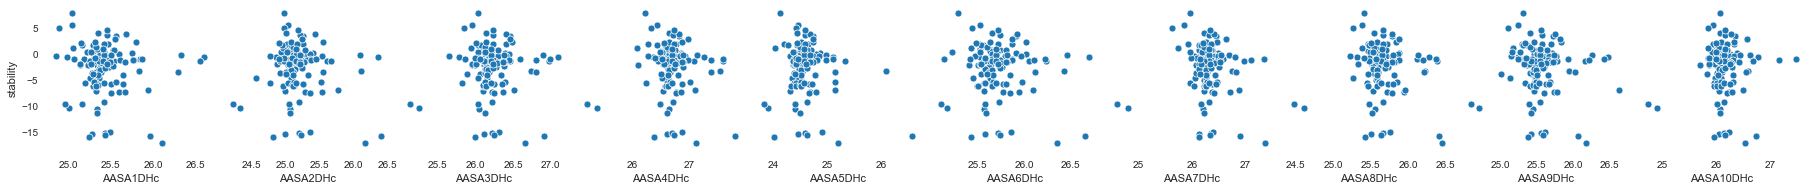

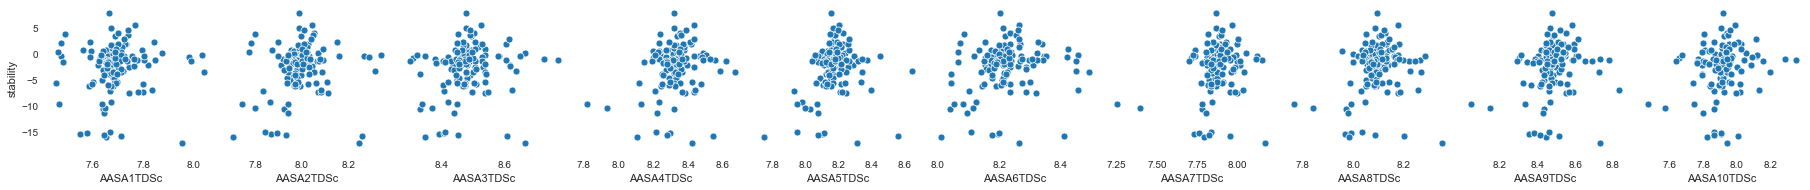

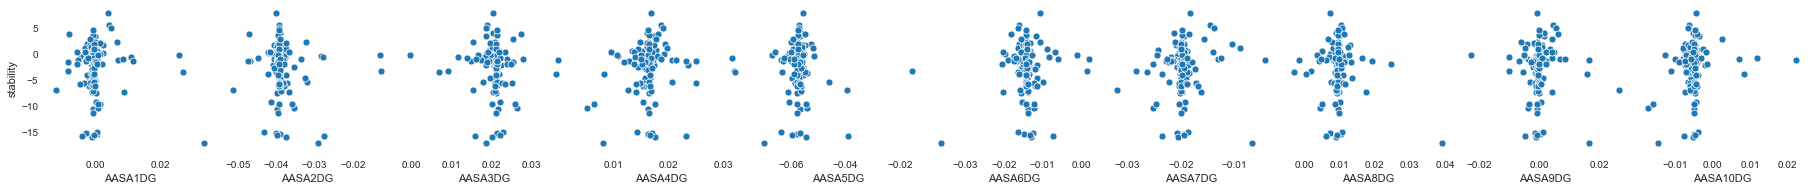

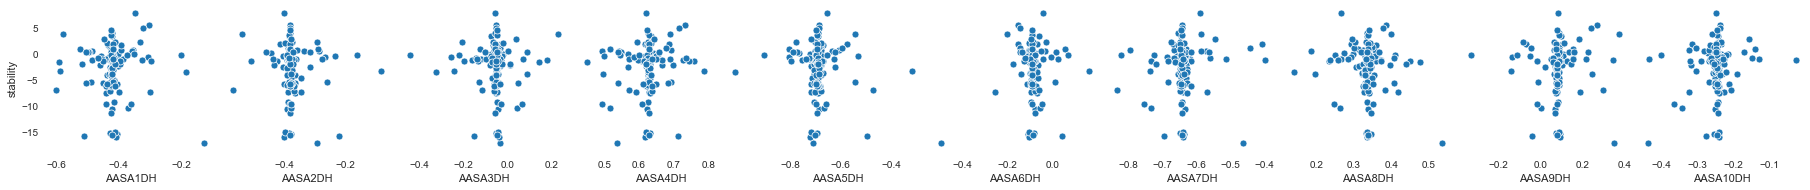

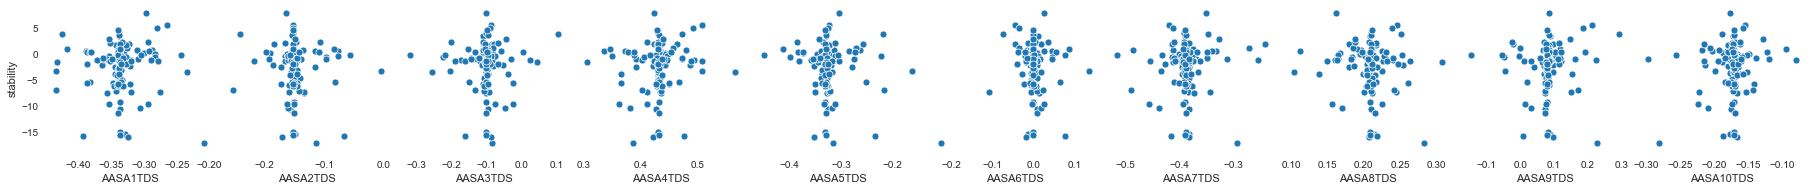

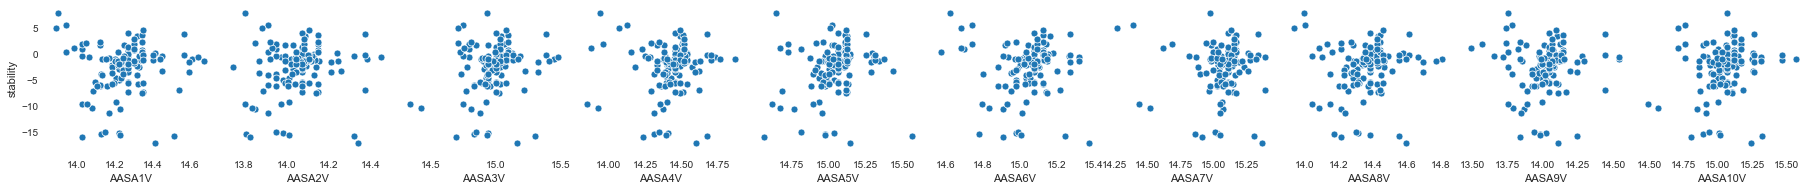

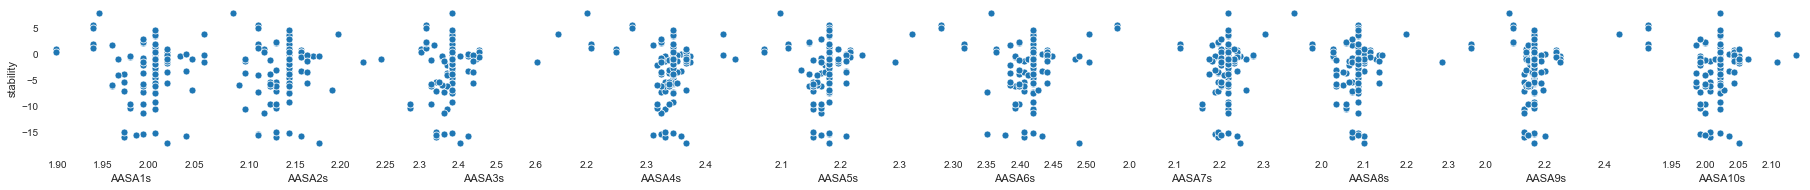

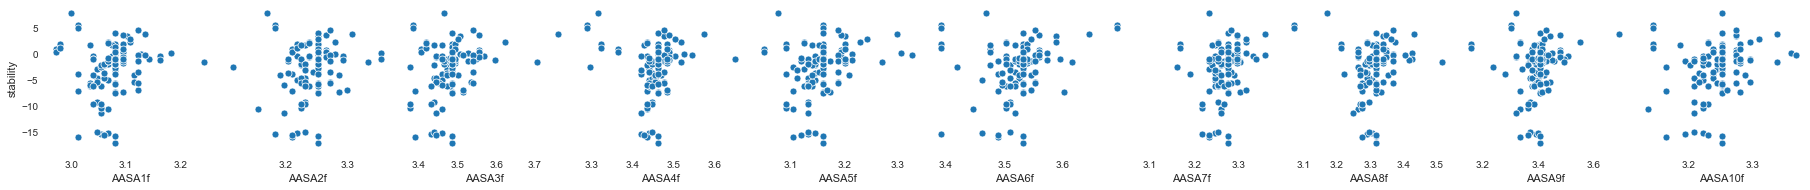

In [119]:
plot_descriptors_against_stability(HLYZ)

### Dimensionality reduction

In order to inspect data in more detail, we first need to find a way to reduce the 480 columns. When collecting data, each descriptor of a protein is measured 10 times. So, we calculate the mean of the 10 measurements for each of the descriptors. Thus, our data of 480 columns is reduced to only 48. The 10 measurements for a descriptor are registered in ordered and contiguous columns of the dataset. An example is the first descriptor *_AASAK0_*, which measurements are *_1AASAK0_*, *_2AASAK0_*, ..., *_10AASAK0_*. All 3 datasets share the same format. The following functions are used to average the descriptors measurements.

The following code reduces the data to 50 columns, including stability and protein name.

### Data transformation

#### Descriptor aggregation

Here some descriptor aggregation is performed as an alternative to feature selection.

In [53]:
def aggregate_properties_descriptors(df, method):
    #Creates a new dataframe from original 'name' and 'stability' columns
    new_df = df.loc[:, ['id', 'stability']]
    
    #Creates a dictionary that maps property names to its descriptors aggreation.
    aggregations = {property_name: descriptors_aggregation for property_name, descriptors_aggregation in aggregate(df, method)}
    
    #Creates columns for each property in the new dataframe.
    return new_df.assign(**aggregations)

def aggregate(df, method):
    for i in range(48): #For each one of the 48 descriptors
        
        # Extracts a dataframe containing descriptors associated with property i
        descriptors = df.iloc[:, 10 * i + 2: 10 * i + 12]
        property_name = descriptors.columns[1][1:]
        
        if(method == 'mean'):
            aggregation = aggregate_using_mean(descriptors)
        elif(method == 'pca'):
            aggregation = aggregate_using_pca(descriptors)
        elif(method == 'rel_std'):
            aggregation = aggregate_using_rel_std(descriptors)
        else:
            aggregation= np.array([])
        
        yield property_name, aggregation
    

def aggregate_using_rel_std(descriptors):
    return (descriptors.std(axis ='columns').to_numpy() / descriptors.mean(axis ='columns').to_numpy())*100

def aggregate_using_pca(descriptors):
    pca = PCA(n_components=1)
    return pca.fit_transform(preprocessing.scale(descriptors)).flatten()

def aggregate_using_mean(descriptors):
    return descriptors.mean(axis ='columns').to_numpy()

In [55]:
transformed_p1STN = aggregate_properties_descriptors(p1STN, method='pca')
transformed_p4LYZ = aggregate_properties_descriptors(p4LYZ, method='pca')
transformed_p1BPI = aggregate_properties_descriptors(p1BPI, method='pca')
transformed_HLYZ = aggregate_properties_descriptors(HLYZ, method='pca')

#### Exporting to transformed data to CSV

It is convenient to export the data already preprocessed so it can be used later for EDA and Predictive Modeling 

In [86]:
transformed_data_path = "../../data/processed/transformed/"

In [232]:
transformed_p1STN.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p1STN.csv', index=False)
transformed_p4LYZ.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p4LYZ.csv', index=False)
transformed_p1BPI.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'p1BPI.csv', index=False)
transformed_HLYZ.to_csv(path_or_buf= transformed_data_path + 'pca/' + 'HLYZ.csv', index=False)